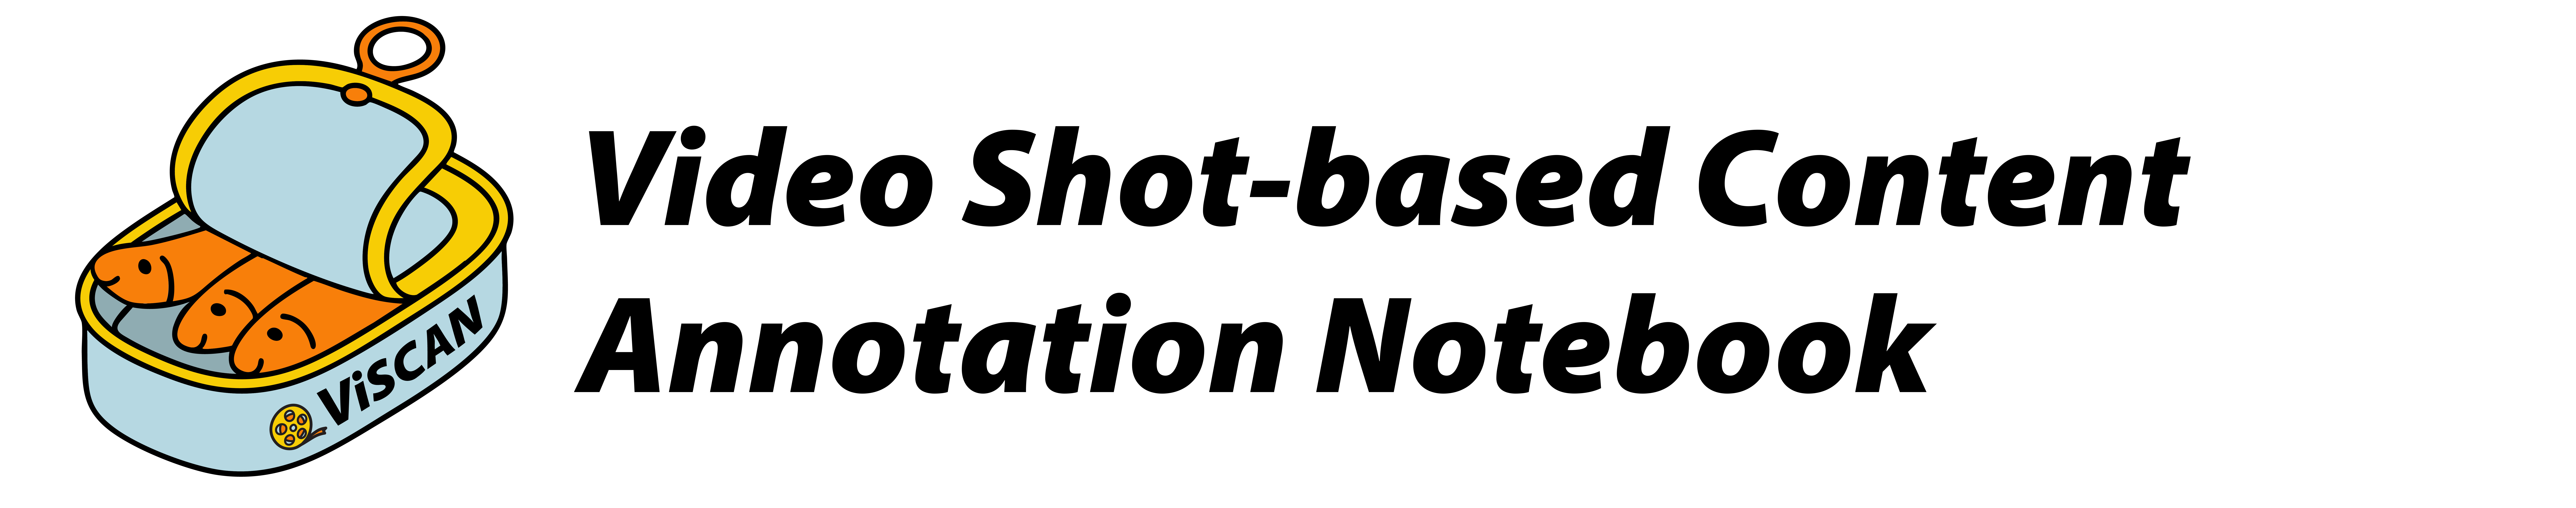

# Introduction
This notebook serves as a proof-of-concept for the methodological approach presented in *"ViSCAT (Video Shot-based Content Annotation Toolkit): Enabling Distant Viewing of short-form videos through shot analysis and timeline visualizations"*. It operationalizes the below analytical workflow and incorporates computational algorithms for processing and annotation. *ViSCAT* is envisioned to enable distant viewing (Arnold and Tilton 2019) of short-form videos for the purposes of style analysis. It is designed to be interoperable with 4CAT (Peeters and Hagen 2022) and intended to be deployed within 4CAT in the future.

This notebook packages the processors as functions for ease of repeated use. It is split into two main parts; first, are the thumbnail annotation processors (TAPs) which analyzes shot thumbnails and adds annotations to the shot dataframe. The second are visualization and data translation processors, which supports exploratory data analysis of the dataset.

---
Prepared by Mike Chow and Shifan Huang

Notebook compiled by Mike Chow

Graphic design by Mike Chow


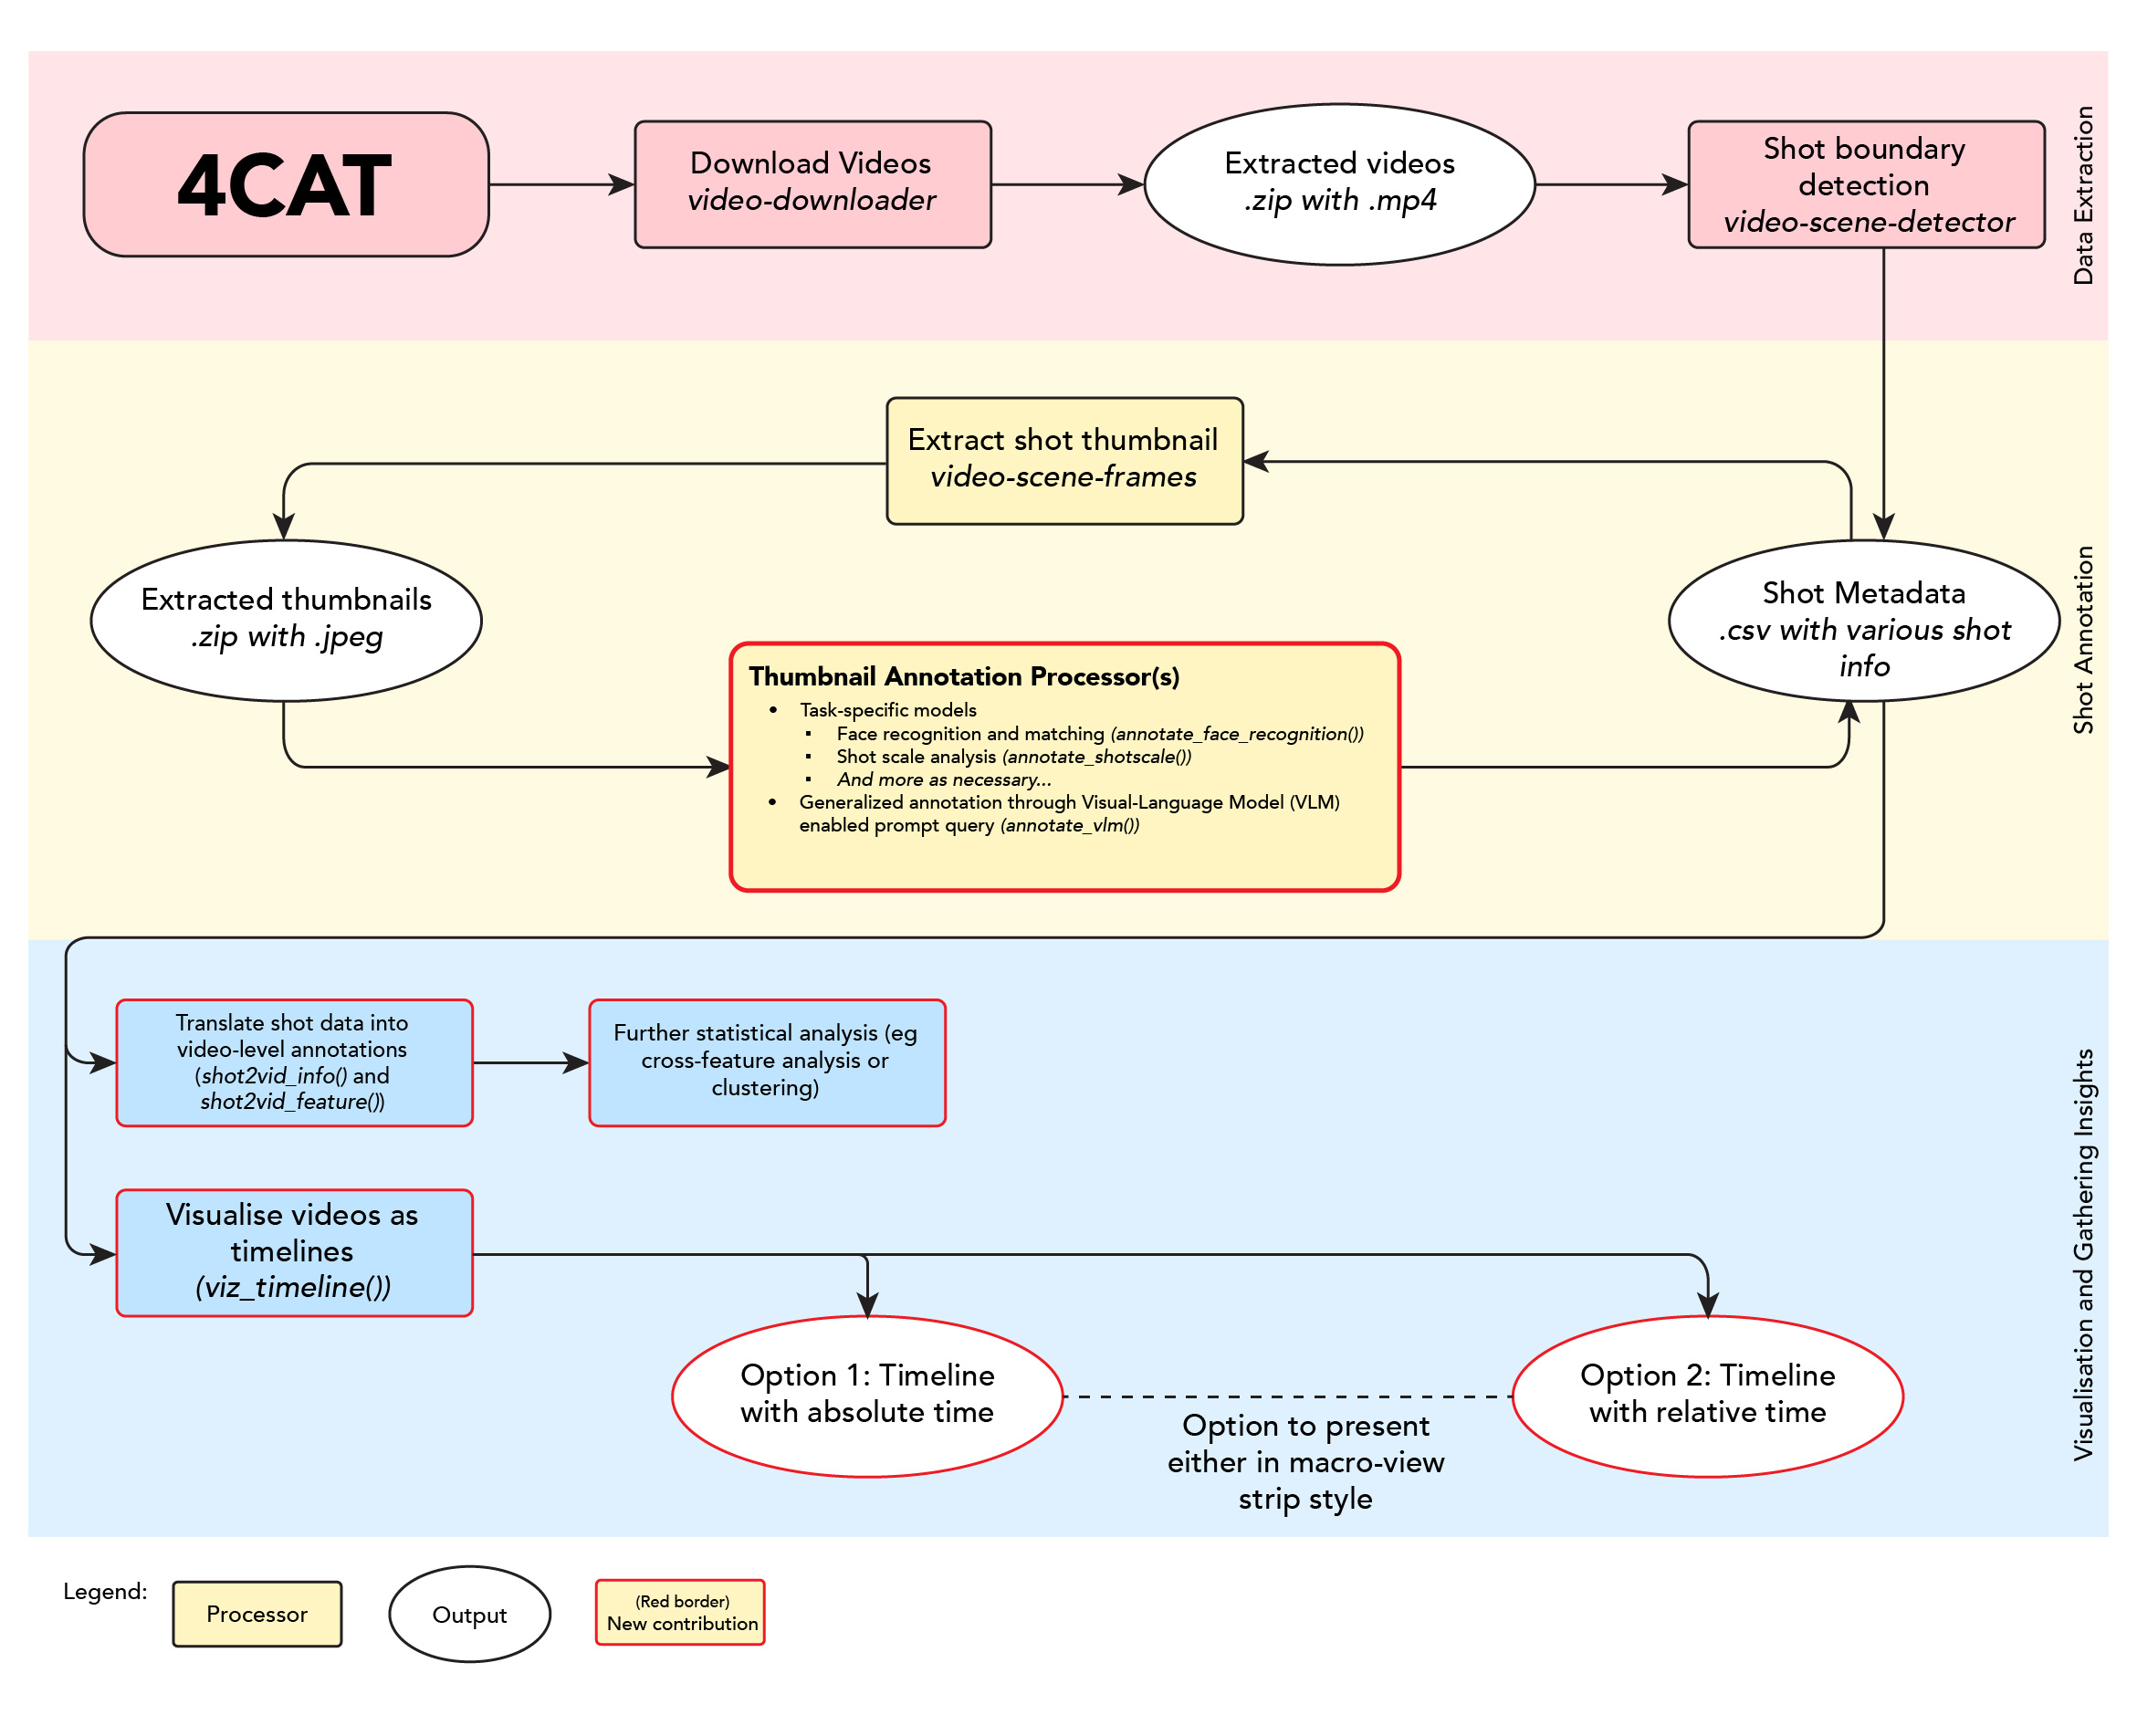

# 0. Initialize libraries

In [74]:
import os
import re
import ast
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta, datetime

# 1. Load Extracted Data
This notebook is designed to be interoperable with video datasets from 4CAT. It relies on its shot boundary detection processor based on ```PySceneDetect```. The following processors are required to be run:
1. Download videos - Loads videos with links from the dataset
2. Detect scenes in video - Performs shot boundary detection and returns a ```.csv``` containing metadata for each shot
3. Extract first frames in each scene - Downloads the first frame of each scene as a thumbnail

Please download the following files and load them into the notebook by providing their file path:
1. ```video_csv``` - The parent ```.csv``` containing the scraped data for each video
2. ```scene_csv``` - The ```.csv``` containing the metadata for the shot splits in videos
3. thumbnail folder - The parent folder containing the thumbnails for shots in videos

In [ ]:
# If running from Google Colab, run this cell; Please note that many of this notebook's functions (eg VLM annotation) are unable to run in Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [249]:
# Load file paths
VIDEO_CSV_PATH = "/Users/mikechow.sg/Documents/03a UvA/4CAT/Qwen/random-sample-oct-2023-idf-dataset-2765e716c4281cfa216dae395b39560c.csv"  # .csv containing metadata for each video in the dataset
scene_csv_path = "/Users/mikechow.sg/Documents/03a UvA/4CAT/Qwen/video-scene-detector-6b4f28a7285c12d649b0fd8e7eb90698.csv"  # .csv containing metadata for shots found in each video
frames_folder = "/Users/mikechow.sg/Documents/03a UvA/4CAT/Qwen/video_scene_frames"  # folder containing thumbnails for each shot found in the video
output_dir = "/Users/mikechow.sg/Documents/03a UvA/4CAT/Qwen"  # Output path to write files (?)

In [251]:
# Error checking to ensure the correct CSV files are loaded

# Check video csv
if not VIDEO_CSV_PATH:
    raise ValueError("Please specify the path to the video CSV file.")
else:
    try:
        df_video = pd.read_csv(VIDEO_CSV_PATH)
        required_columns = ["id", # Sample check of required columns to ensure correct csv is loaded
                            "body",
                            "timestamp",
                            "video_url",
                            "tiktok_url",
                            "plays",
                            "hashtags"]
        if not set(required_columns).issubset(set(df_video.columns)):
            raise ValueError("The video .csv file does not appear to be the correct dataset. Please check and load the correct dataset")
        else:
            # Convert data types and preview df_video
            df_video['timestamp'] = pd.to_datetime(df_video['timestamp'])
            print("Video CSV file loaded successfully as df_video.")

    except Exception as e:
        print("Error reading video CSV file.")
        print(e)


# Repeat for scene metadata
if not scene_csv_path:
    raise ValueError("Please specify the path to the scene CSV file.")
else:
    try:
        df_scene = pd.read_csv(scene_csv_path)
        required_columns = ["id", # Sample check of required columns to ensure correct csv is loaded
                            "url",
                            "start_frame",
                            "start_time",
                            "end_frame",
                            "end_time",
                            "scene_num",
                            "total_video_duration"
                            ]
        if not set(required_columns).issubset(set(df_scene.columns)):
            raise ValueError("The scene .csv file does not appear to be the correct dataset. Please check and load the correct dataset")
        else:
            # Convert data types
            df_scene['start_time'] = pd.to_timedelta(df_scene['start_time'])
            df_scene['end_time'] = pd.to_timedelta(df_scene['end_time'])
            df_scene['total_video_duration'] = pd.to_timedelta(df_scene['total_video_duration'])
            print("Scene CSV file loaded successfully as df_scene.")

    except Exception as e:
        print("Error reading scene CSV file.")
        print(e)

Video CSV file loaded successfully as df_video.
Scene CSV file loaded successfully as df_scene.


In [252]:
df_video

id            thread_id author author_full  \
0  7295526580741229825  7295526580741229825    idf         IDF   
1  7294420810465430785  7294420810465430785    idf         IDF   
2  7293266381401754881  7293266381401754881    idf         IDF   
3  7293183558871551234  7293183558871551234    idf         IDF   
4  7290776842250833153  7290776842250833153    idf         IDF   

   author_followers  author_likes  author_videos  \
0            535900            80            875   
1            535900            80            875   
2            535900            80            875   
3            535900            80            875   
4            535900            80            875   

                                       author_avatar  \
0  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
1  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
2  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
3  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
4  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   

                                                body           timestamp  ...  \
0  In response to launches from Syria toward Isra... 2023-10-29 23:29:23  ...   
1  These words will never compare to the torture ... 2023-10-26 23:58:24  ...   
2  Individually we are strong, together we are a ... 2023-10-23 21:18:32  ...   
3  All the context you need //  #hamasisis #stand... 2023-10-23 15:57:10  ...   
4  IDF Spokesperson, RAdm. Daniel Hagari speaks a... 2023-10-17 04:17:51  ...   

   shares   plays                                     hashtags  \
0      13   65900                                  idf,soldier   
1      38   77400                         idf,israel,testimony   
2    2265  989800                           idf,soldier,israel   
3     129   67600  hamasisis,standwithisrael,israelunderattack   
4     880  212100                                   idf,israel   

                                    challenges diversification_labels  \
0                                  idf,soldier                    NaN   
1                         idf,israel,testimony                    NaN   
2                           idf,soldier,israel                    NaN   
3  hamasisis,standwithisrael,israelunderattack                    NaN   
4                                   idf,israel                    NaN   

  location_created                               stickers  effects warning  \
0              NaN  Counter Speech 🚨 Operational Update 🚨      NaN     NaN   
1              NaN                                    NaN      NaN     NaN   
2              NaN                         Counter Speech      NaN     NaN   
3              NaN                                    NaN      NaN     NaN   
4              NaN                         Counter Speech      NaN     NaN   

  missing_fields  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 36 columns]

In [253]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      5 non-null      int64         
 1   thread_id               5 non-null      int64         
 2   author                  5 non-null      object        
 3   author_full             5 non-null      object        
 4   author_followers        5 non-null      int64         
 5   author_likes            5 non-null      int64         
 6   author_videos           5 non-null      int64         
 7   author_avatar           5 non-null      object        
 8   body                    5 non-null      object        
 9   timestamp               5 non-null      datetime64[ns]
 10  unix_timestamp          5 non-null      int64         
 11  is_duet                 5 non-null      object        
 12  is_ad                   5 non-null      object        

In [254]:
# Preview df_scene again
df_scene

id                  url  \
0    7295526580741229825.mp4_scene_1  7295526580741229825   
1    7295526580741229825.mp4_scene_2  7295526580741229825   
2    7295526580741229825.mp4_scene_3  7295526580741229825   
3    7295526580741229825.mp4_scene_4  7295526580741229825   
4    7295526580741229825.mp4_scene_5  7295526580741229825   
5    7293266381401754881.mp4_scene_1  7293266381401754881   
6    7293266381401754881.mp4_scene_2  7293266381401754881   
7    7293266381401754881.mp4_scene_3  7293266381401754881   
8    7293266381401754881.mp4_scene_4  7293266381401754881   
9    7293266381401754881.mp4_scene_5  7293266381401754881   
10   7293266381401754881.mp4_scene_6  7293266381401754881   
11   7293266381401754881.mp4_scene_7  7293266381401754881   
12   7293266381401754881.mp4_scene_8  7293266381401754881   
13   7293266381401754881.mp4_scene_9  7293266381401754881   
14  7293266381401754881.mp4_scene_10  7293266381401754881   
15  7293266381401754881.mp4_scene_11  7293266381401754881   
16  7293266381401754881.mp4_scene_12  7293266381401754881   
17  7293266381401754881.mp4_scene_13  7293266381401754881   
18  7293266381401754881.mp4_scene_14  7293266381401754881   
19  7293266381401754881.mp4_scene_15  7293266381401754881   
20  7293266381401754881.mp4_scene_16  7293266381401754881   
21  7293266381401754881.mp4_scene_17  7293266381401754881   
22  7293266381401754881.mp4_scene_18  7293266381401754881   
23   7290776842250833153.mp4_scene_1  7290776842250833153   
24   7290776842250833153.mp4_scene_2  7290776842250833153   
25   7290776842250833153.mp4_scene_3  7290776842250833153   
26   7290776842250833153.mp4_scene_4  7290776842250833153   
27   7290776842250833153.mp4_scene_5  7290776842250833153   
28   7290776842250833153.mp4_scene_6  7290776842250833153   
29   7290776842250833153.mp4_scene_7  7290776842250833153   
30   7290776842250833153.mp4_scene_8  7290776842250833153   
31   7290776842250833153.mp4_scene_9  7290776842250833153   
32  7290776842250833153.mp4_scene_10  7290776842250833153   
33  7290776842250833153.mp4_scene_11  7290776842250833153   
34  7290776842250833153.mp4_scene_12  7290776842250833153   
35  7290776842250833153.mp4_scene_13  7290776842250833153   

                        from_dataset  start_frame             start_time  \
0   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
1   2765e716c4281cfa216dae395b39560c           50        0 days 00:00:02   
2   2765e716c4281cfa216dae395b39560c          100        0 days 00:00:04   
3   2765e716c4281cfa216dae395b39560c          150        0 days 00:00:06   
4   2765e716c4281cfa216dae395b39560c          200        0 days 00:00:08   
5   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
6   2765e716c4281cfa216dae395b39560c           43 0 days 00:00:01.433000   
7   2765e716c4281cfa216dae395b39560c           74 0 days 00:00:02.467000   
8   2765e716c4281cfa216dae395b39560c          107 0 days 00:00:03.567000   
9   2765e716c4281cfa216dae395b39560c          142 0 days 00:00:04.733000   
10  2765e716c4281cfa216dae395b39560c          176 0 days 00:00:05.867000   
11  2765e716c4281cfa216dae395b39560c          205 0 days 00:00:06.833000   
12  2765e716c4281cfa216dae395b39560c          239 0 days 00:00:07.967000   
13  2765e716c4281cfa216dae395b39560c          275 0 days 00:00:09.167000   
14  2765e716c4281cfa216dae395b39560c          314 0 days 00:00:10.467000   
15  2765e716c4281cfa216dae395b39560c          361 0 days 00:00:12.033000   
16  2765e716c4281cfa216dae395b39560c          389 0 days 00:00:12.967000   
17  2765e716c4281cfa216dae395b39560c          417 0 days 00:00:13.900000   
18  2765e716c4281cfa216dae395b39560c          447 0 days 00:00:14.900000   
19  2765e716c4281cfa216dae395b39560c          487 0 days 00:00:16.233000   
20  2765e716c4281cfa216dae395b39560c          517 0 days 00:00:17.233000   
21  2765e716c4281cfa216dae395b39560c          547 0 days 00:00:18.233000   
22  2765e716c4281cfa216dae39

# 2. Thumbnail Annotator Processors
This section contains three example processors for thumbnail annotation. More processors (such as those in ```dvt``` (Arnold and Tilton 2020) can also be incorporated for analysis.
- ```annotate_shotscale()``` - Performs shot scale analysis on a thumbnail
- ```annotate_face_recognition()``` - Performs face recognition on a thumbnail dataset
- ```annotate_vlm()``` - Uses a VLM and a user-submitted prompt to analyze and annotate thumbnails

## 2a. Shot Scale Analysis

This processor uses MediaPipe’s pose detection model (mp_pose.Pose()) to extract 33 keypoints from the human body for shot scale classification in video frames.
Please run the initialisation block, followed by the function ```annotate_shotscale()``` as listed below.

*Prepared by Shifan Huang*

### Initialize Libraries

In [173]:
!pip install opencv-python matplotlib mediapipe numpy
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall mediapipe scipy

import os
import cv2
import csv
import re
import json
import pandas as pd
import numpy as np
import mediapipe as mp
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import pandas as pd
from PIL import Image

Python(72175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 27.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 MB 15.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 26.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.5/671.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 26.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


Python(72201) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 24.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.4 which is incompatible.


Python(72208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached mediapipe-0.10.21-cp310-cp310-macosx_11_0_universal2.whl.metadata (9.9 kB)
  Using cached scipy-1.15.2-cp310-cp310-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached jax-0.5.3-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (1.2 kB)
  Using cached matplotlib-3.10.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
  Using cached protobuf-4.25.6-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
  Using cached sounddevice-0.5.1-py3-none-macosx_10_6_x86_64.macosx_10_6_universal2.whl.metadata (1.4 kB)
  Using cached sentencepiece-0.2.0-

### ```annotate_shotscale()``` Shot scale classification & Annotator

This function uses MediaPipe’s pose detection model (mp_pose.Pose()) to extract 33 keypoints from the human body for shot scale classification in video frames.

**Parameters**

- ```df_scene``` - Main scene dataframe; Defaults to the variable ```df_scene```
- ```frames_folder``` - Folder path of thumbnails; Defaults to the variable ```THUMBNAIL_PATH```

Returns updated ```df_scene```



In [255]:

# Initialize MediaPipe
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Extract keypoints
def get_keypoints(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)
    keypoints = [None] * 33
    if results.pose_landmarks:
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            keypoints[idx] = (int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0]))
    return keypoints

# shot scale classification
def classify_shot_scale(keypoints, frame_height):
    if not keypoints or keypoints[0] is None:
        return "Empty Shot"

    point_names = {
        0: 'Nose', 1: 'LEye', 2: 'REye', 3: 'LEar', 4: 'REar',
        11: 'LShoulder', 12: 'RShoulder', 23: 'LHip', 24: 'RHip',
        25: 'LKnee', 26: 'RKnee', 27: 'LAnkle', 28: 'RAnkle'
    }

    # Stores the names of detected keypoints (e.g., "Nose")
    key_parts = []
    # Stores the corresponding vertical positions (y-coordinates) of those points
    y_values = []

    for idx, pt in enumerate(keypoints):
        if pt is not None and idx in point_names:
            key_parts.append(point_names[idx])
            y_values.append(pt[1])

    if not y_values:
        #  If no valid keypoints are detected (e.g., no person in the frame), the shot is immediately labeled as "Empty Shot".
        return "Empty Shot"

    # Compute min_y and max_y from the detected keypoints to determine the person’s vertical height within the frame.
    min_y, max_y = min(y_values), max(y_values)

    # Focus on particular body parts and grouping of parts for analysis
    body_parts = set(key_parts)
    head_parts = {'Nose', 'REye', 'LEye', 'REar', 'LEar'}
    chest_below_parts = {'MidHip', 'RHip', 'LHip', 'RKnee', 'LKnee'}
    feet_parts = {'RAnkle', 'LAnkle'}

    if body_parts.intersection(head_parts) and body_parts.intersection(feet_parts):
        # head_parts and feet_parts keypoints are both detected

        if (max_y - min_y) <= frame_height / 2:
            # If person height ≤ 50% of frame height
            return "Long Shot"
        else:
            # If person height > 50% of frame height
            return "Full Shot"
    elif body_parts.intersection(head_parts) and not body_parts.intersection(feet_parts) and body_parts.intersection(chest_below_parts):
        # Upper body visible; head_parts + chest_below_parts detected, but feet_parts not visible
        return "Medium Shot"
    elif body_parts.intersection(head_parts) and not body_parts.intersection(chest_below_parts) and 'Neck' in body_parts:
        # Head and Shoulders Only (Medium Close-Up); head_parts and Neck detected, no chest_below_parts keypoints
        return "Medium Close-Up"
        # Head Only; Only head_parts keypoints are detected
    elif body_parts.intersection(head_parts) and 'Neck' not in body_parts:
        return "Close-Up"
    else:
        #  If none of the above rules are met, the frame defaults to "Close-Up" as a fallback classification.
        return "Close-Up"

# Extract scene number from filename
def extract_scene_num(filename):
    match = re.search(r'scene[_\-]?(\d+)', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Main function: annotate shot scales and save back to CSV
def annotate_shotscale(df_scene=df_scene, frames_folder=frames_folder):
    '''

    :param df_scene:
    :param frames_folder:
    :return: df_scene: updated df_scene with 'shot_scale' annotation column
    '''
    # Obtain list of videos
    id_list = df_scene['url'].unique().tolist()

    # Loop through list of videos
    for video_id in id_list:
        # video_id example: '7295526580741229825'
        df_scenes = df_scene[df_scene['url'] == video_id]
        scene_list = df_scenes['id'] # Obtain list of scene ids in a video
        # Loop through scenes in specified video
        for scene_id in scene_list:
            # scene_id example '7295526580741229825.mp4_scene_1'
            cleaned_id = re.sub(r'\.mp4', '', scene_id)
            # cleaned_id example '7295526580741229825_scene_1'
            thumbnail_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')
            print(f'Processing {cleaned_id}.jpeg...')

            frame = cv2.imread(thumbnail_path)
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            if frame is None:
                continue # Skip if no image is found
            keypoints = get_keypoints(frame) # Obtain keypoints
            shot_scale = classify_shot_scale(keypoints, frame.shape[0]) # Obtain shot scale

            # Append to new column
            df_scene.loc[df_scene['id'] == scene_id, 'shot_scale'] = shot_scale


    # Output updated CSV with added annotations
    scene_data_path = os.path.join(output_dir, "updated_scene_data.csv")
    df_scene.to_csv(scene_data_path, index=False)

    # Show preview
    print(f"Shot scale annotations written to: {scene_data_path}")
    print("\nPreview of updated DataFrame:")
    print(df_scene[["scene_num", "url", "shot_scale"]].head())

    return df_scene

I0000 00:00:1744848064.719597 8767864 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1


In [256]:
df_scene = annotate_shotscale(df_scene=df_scene, frames_folder=frames_folder)

Processing 7295526580741229825_scene_1.jpeg...
Processing 7295526580741229825_scene_2.jpeg...
Processing 7295526580741229825_scene_3.jpeg...
Processing 7295526580741229825_scene_4.jpeg...
Processing 7295526580741229825_scene_5.jpeg...
Processing 7293266381401754881_scene_1.jpeg...
Processing 7293266381401754881_scene_2.jpeg...
Processing 7293266381401754881_scene_3.jpeg...
Processing 7293266381401754881_scene_4.jpeg...
Processing 7293266381401754881_scene_5.jpeg...
Processing 7293266381401754881_scene_6.jpeg...
Processing 7293266381401754881_scene_7.jpeg...
Processing 7293266381401754881_scene_8.jpeg...
Processing 7293266381401754881_scene_9.jpeg...
Processing 7293266381401754881_scene_10.jpeg...
Processing 7293266381401754881_scene_11.jpeg...
Processing 7293266381401754881_scene_12.jpeg...
Processing 7293266381401754881_scene_13.jpeg...
Processing 7293266381401754881_scene_14.jpeg...
Processing 7293266381401754881_scene_15.jpeg...
Processing 7293266381401754881_scene_16.jpeg...
Proces

### Visualise Shot Scale Predictions alongside thumbnails

```viz_shotscale_results()``` is a function that visualizes the results of shot scale annotation and displays them next to the shot for review

**Optional Parameters**
- ```df_scene``` - Main scene dataframe; Defaults to the variable ```df_scene```
- ```frames_folder``` - Folder path of thumbnails; Defaults to the variable ```THUMBNAIL_PATH```

In [349]:
def viz_shotscale_results(df_scene=df_scene, frames_folder=frames_folder):
    """
    Visualizes shot scale analysis results

    :param df_scene: DataFrame containing the video URLs, scene IDs, and related information.
    :type df_scene: pandas.DataFrame
    :param frames_folder: Folder path where thumbnail image files for each scene are stored.
                          Image files are expected to follow a specific naming convention.
                          Defaults to `frames_folder`.
    :type frames_folder: str
    :return: None. The function creates and shows visualizations for the given video(s)
             and their corresponding scenes.
    :rtype: None
    """

    # Check for the correct dataframe
    if not 'shot_scale' in df_scene.columns:
            raise ValueError("The dataframe lacks 'shot_scale' column. Have you performed shot scale analysis?")

    # Visualize by video
    video_list = df_scene['url'].unique()
    # Set maximum thumbnails per row to prevent overcrowding
    max_row_len = 10

    for video in video_list:
        df_scene_for_vid = df_scene[df_scene['url'] == video].reset_index(drop=True)
        num_scenes = len(df_scene_for_vid)
        video_id = df_scene_for_vid.iloc[0]['url']

        num_rows = num_scenes // max_row_len + 1 # Ceiling division to calculate number of rows
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Shot Scale Analysis for shot thumbnails in {video_id}'", fontsize=12)

        plt.axis('off')


        # Loop through scenes in video
        for i, scene in df_scene_for_vid.iterrows():
            scene_id = scene['id']
            # scene_id example '7295526580741229825.mp4_scene_1'
            cleaned_id = re.sub(r'\.mp4', '', scene_id)
            # cleaned_id example '7295526580741229825_scene_1'
            # create image path based on video_id
            image_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')

            image = face_recognition.load_image_file(image_path)

            # Display image
            if num_scenes > max_row_len:
                plt.subplot(num_rows, max_row_len, i+1)
            else:
                plt.subplot(1, num_scenes, i+1)

            plt.title(f"Shot scale for scene {scene['scene_num']}: \n{scene['shot_scale']}", fontsize=5)
            plt.imshow(image)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

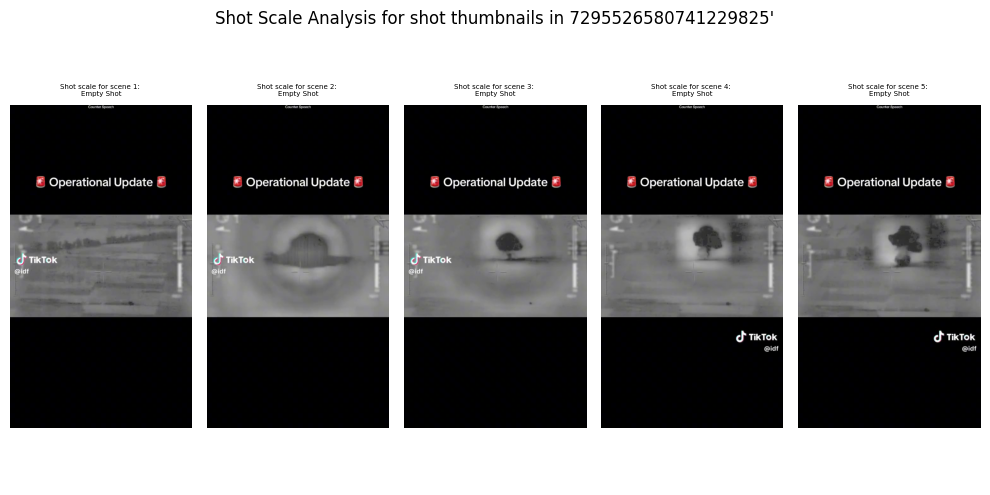

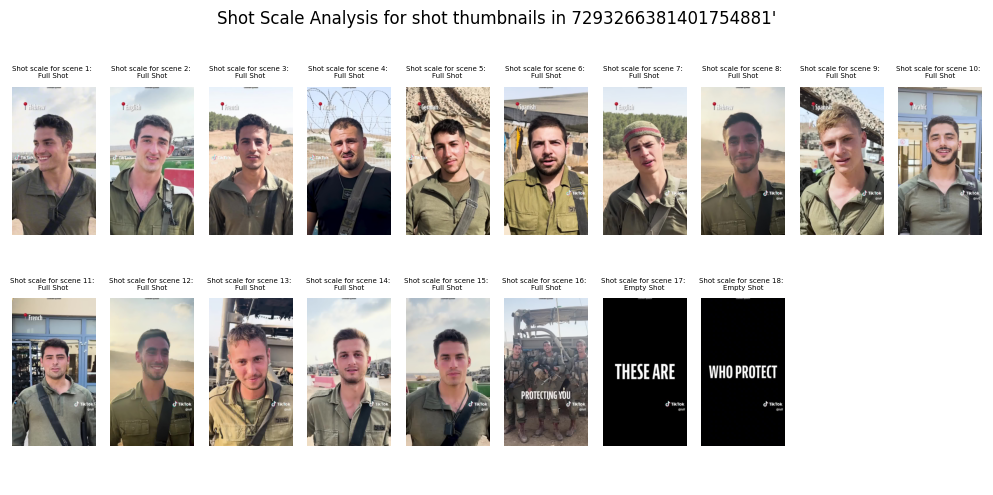

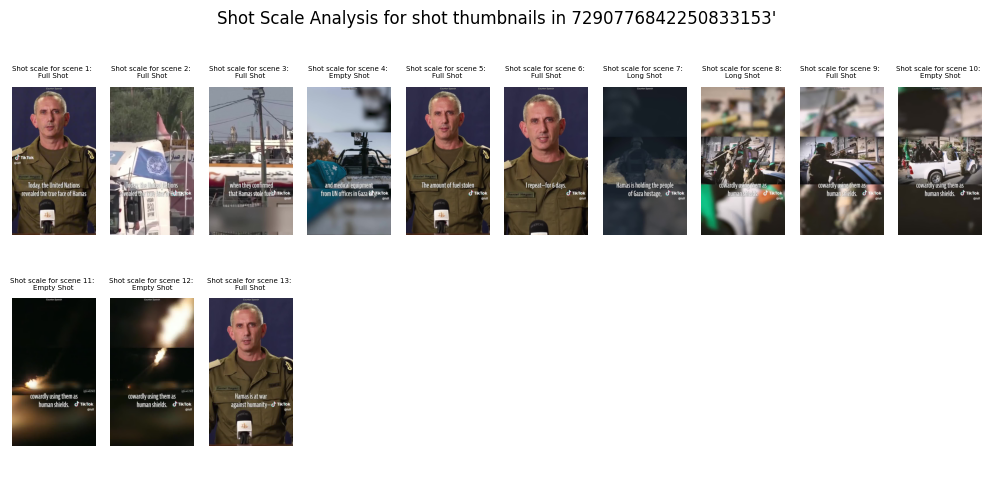

In [350]:
viz_shotscale_results(df_scene, frames_folder)

## 2b. Face Detection and Recognition

This processor uses ```face_recognition``` (https://github.com/ageitgey/face_recognition) to detect and match faces in video thumbnails.
Please run the initialisation block, followed by the function ```annotate_face_recognition(df_scene, frames_folder, reference_faces)``` as listed below.

*Prepared by Mike Chow*

### Initialize functions for face recognition

In [322]:
!pip install face_recognition
import face_recognition

Python(97066) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [323]:
# Base function to detect faces
def get_faces(image_path):
    # https://github.com/ageitgey/face_recognition/blob/master/examples/identify_and_draw_boxes_on_faces.py
    image = face_recognition.load_image_file(image_path)
    face_locations_list = face_recognition.face_locations(image)  # Do not assume there's only one person in the image
    face_encodings_list = face_recognition.face_encodings(image, face_locations_list)
    return face_locations_list, face_encodings_list

# Loops through a scene dataset and locates faces
def get_faces_batch(scene_data, frames_folder):

    '''
    :param scene_data: dataframe containing scene data
    :param frames_folder: file path str; Target folder path where the scene thumbnails are stored
    :return: scene_data: Updated dataframe with face_locations_list and face_encodings_list
    '''


    # Initialize empty columns
    scene_data['face_locations_list'] = None
    scene_data['face_encodings_list'] = None
    scene_data['face_count'] = None

    # Loop through all shots
    for i, shot in scene_data.iterrows():
        video_id = shot['url']
        scene_id = shot['id']
        # scene_id example '7295526580741229825.mp4_scene_1'
        cleaned_id = re.sub(r'\.mp4', '', scene_id)
        # cleaned_id example '7295526580741229825_scene_1'
        # create thumbnail path based on video_id
        thumbnail_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')

        try:
            # Attempt to load the image
            image = face_recognition.load_image_file(thumbnail_path)

            # Process the image to get face locations and encodings
            print(f'Processing {cleaned_id}.jpeg...')
            face_locations_list, face_encodings_list = get_faces(thumbnail_path)

            # Update the DataFrame directly in the respective columns
            scene_data.at[i, 'face_locations_list'] = face_locations_list
            scene_data.at[i, 'face_encodings_list'] = face_encodings_list
            scene_data.at[i, 'face_count'] = len(face_encodings_list)

        except FileNotFoundError:
            print(f"Error: File not found at {thumbnail_path}")

        except Exception as e:
            print(f"Error: Could not process {thumbnail_path} due to {str(e)}")

        # Data now contains information of people detected in the video (with their location and encoding)
    return scene_data

# Function to validate user input
def get_valid_input(prompt):
    while True:
        user_input = input(prompt).strip().lower()  # Strips spaces and converts input to lowercase
        if user_input in ['y', 'n']:
            return user_input
        print("Invalid input. Please enter 'y' or 'n'.")

# Function to process user reference faces
def process_user_faces(reference_faces):
    # Processes user input of list of reference face dictionaries

    faces_data = [] # Initialise list of dictionaries containing faces data

    for face in reference_faces:
        print()
        file_path = face["face_path"]
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"Error: {file_path} does not exist. Continuing to next reference shot.")
            continue

        # Load the image using OpenCV
        reference_image = cv2.imread(file_path)

        if reference_image is None:
            print(f"Error: Unable to load the {file_path}. Please check the file format or compatibility.")
            return None

        print(f"Reference image {os.path.basename(file_path)} uploaded successfully!")
        print("Locating face in the reference image...")

        face_encoding_list = face_recognition.face_encodings(reference_image)
        if len(face_encoding_list) == 0:
            print(f"Error: No faces found in the reference image. {file_path}")
            return None
        elif len(face_encoding_list) > 1:
            print(f"Warning: Multiple faces found in the reference image {file_path}. Only the first face will be used.")
            face_encoding = face_encoding_list[0]
        elif len(face_encoding_list) == 1:
            face_encoding = face_encoding_list[0]

        face_label = face["face_label"]

        if face_encoding is not None:
                faces_data.append({'face_label': face_label,
                                   'face_encoding': face_encoding,
                                   'matched_shots': [],
                                   'count': 0})

    return faces_data

# Match similar faces together
def match_faces_in_videos(scene_data, reference_faces):
    '''
    :param scene_data: list of dictionaries containing the scene data
    :return: df_scene_data, df_faces:
    '''
    # Check for valid dataframe; DataFrame needs to have 'face_locations_list' and 'face_encodings_list' as columns

    if reference_faces:
        faces_data = process_user_faces(reference_faces)
    else:
        faces_data = []

    scene_data['face_list'] = None


    # Ask for tolerance input
    while True:
        try:
            # Ask the user for input with default information
            user_input = input("Enter a tolerance value (must be a float between 0 and 1, default is 0.5): ")

            # If the user presses Enter without input, use the default value
            if user_input.strip() == "":
                tolerance = 0.5
                print(f"No input provided. Using default tolerance value: {tolerance}.")
                break

            # Convert the input to float and validate
            tolerance = float(user_input)
            if 0 <= tolerance <= 1:
                print(f"Valid input! Tolerance set to {tolerance}.")
                break
            else:
                print("Error: The value must be between 0 and 1. Please try again.")
        except ValueError:
            print("Error: Please enter a valid float number. Try again.")


    # Loop through scenes
    for i, shot in scene_data.iterrows(): # shot is a dictionary

        # Retrieve face encodings
        face_encodings_list = shot['face_encodings_list']

        # Initialize face_matches for shot; Contains list of face_label (s)
        # Purpose is to track the faces found in a shot
        face_list = []

        for face_encoding in face_encodings_list: # Loop through each face_encoding in list

            match = False # Initialize match

            # Loop through existing matches
            for face in faces_data:  # Dictionary containing existing face information
                result = face_recognition.compare_faces([face['face_encoding']], # Singular face
                                                        face_encoding, # Current face we are checking
                                                        tolerance = tolerance # Adjust tolerance as needed
                                                        # Lower is stricter
                                                        )

                if result[0]: # For True; Since we are only comparing one face at a time, there will only be one result
                    print(f'{shot["id"]} matches existing face ({face["face_label"]}).')
                    face['matched_shots'].append(shot['id'])
                    face['count'] += 1
                    face_list.append(face['face_label']) # Update list of face_labels
                    match = True
                    break

            if not match: # If there is no existing match
                print(f'New face detected in {shot["id"]}')
                # Add new face into face_list
                face_label = f'face_{len(faces_data)}'
                faces_data.append({'face_label': face_label,
                                           'face_encoding': face_encoding,
                                           'matched_shots': [shot['id']],
                                           'count': 1
                                                      })
                # Add to rolling list of face_labels for the current shot
                face_list.append(face_label)

        # Add face_list to scene_data
        scene_data.at[i, 'face_list'] = face_list
    faces_data = pd.DataFrame(faces_data) # Convert to DataFrame
    return scene_data, faces_data

In [325]:
# Main function
def annotate_face_recognition(df_scene=df_scene, frames_folder=frames_folder, reference_faces=[]):
    '''

    :param df_scene: target scene dataframe
    :param frames_folder: folder directory of scene thumbnails
    :param reference_faces: list of dictionaries with keys of 'face_path' and 'face_label' containing reference faces to be matched against
    :return: df_scene: updated scene dataframe with list of faces found; df_faces: dataframe with faces in the scene
    '''
    # Execute face_recog on shot thumbnails
    df_scene = get_faces_batch(df_scene, frames_folder)

    print('\nThumbnails processed! Proceeding to identify recurring faces.')

    # We now identify recurring faces in the whole dataset
    df_scene, df_faces = match_faces_in_videos(df_scene, reference_faces)

    scene_data_path = os.path.join(output_dir, "updated_scene_data.csv")
    faces_path = os.path.join(output_dir, "faces_data.csv")
    df_scene.to_csv(scene_data_path, index=False)
    print("Updated scene data saved to:", scene_data_path)
    df_faces.to_csv(faces_path, index=False)
    print("Face data saved to:", faces_path)

    print()
    print('Done!')
    return df_scene, df_faces

### ```annotate_face_recognition()``` Face detection and recognition processor
Identifies faces in a thumbnail and matches similar faces in the dataset

**Parameters**
- ```df_scene``` - Main scene dataframe; Defaults to the variable ```df_scene```
- ```frames_folder``` - Folder path of thumbnails; Defaults to the variable ```frames_folder```
- ```reference_faces``` - OPTIONAL: List of dictionaries with keys of 'face_path' and 'face_label' containing reference faces to be matched against; Defaults to ```[]``` (empty list)


**User Inputs**
- Tolerance: A tolerance value for matching faces together between 0 and 1. The lower the tolerance, the stricter the matching will be


Returns updated ```df_scene``` and ```df_faces``` which contains a dataframe of faces found and exports them as CSV files.


In [326]:
# OPTIONAL: List of dictionaries containing paths and labels for reference faces as the user sees fit
'''
Dictionary format
{"face_path": "file path to reference image", "face_label": "label for this particular face"},
'''
reference_faces = [{
                    "face_path": "/Users/mikechow.sg/Documents/03a UvA/4CAT/Qwen/reference_faces/RAdm Daniel Hagari_M.png",
                    "face_label": "RAdm Daniel Hagari"
                    },
]

# If there is no need to submit reference_faces (Default value in annotate_face_recognition is [] anyway)
# reference_faces = []

In [327]:
# df_scene, df_faces = annotate_face_recognition() # default function; Unnecessary to add variables assuming variables have not been amended

df_scene, df_faces = annotate_face_recognition(df_scene=df_scene, frames_folder=frames_folder, reference_faces=reference_faces)

Processing 7295526580741229825_scene_1.jpeg...
Processing 7295526580741229825_scene_2.jpeg...
Processing 7295526580741229825_scene_3.jpeg...
Processing 7295526580741229825_scene_4.jpeg...
Processing 7295526580741229825_scene_5.jpeg...
Processing 7293266381401754881_scene_1.jpeg...
Processing 7293266381401754881_scene_2.jpeg...
Processing 7293266381401754881_scene_3.jpeg...
Processing 7293266381401754881_scene_4.jpeg...
Processing 7293266381401754881_scene_5.jpeg...
Processing 7293266381401754881_scene_6.jpeg...
Processing 7293266381401754881_scene_7.jpeg...
Processing 7293266381401754881_scene_8.jpeg...
Processing 7293266381401754881_scene_9.jpeg...
Processing 7293266381401754881_scene_10.jpeg...
Processing 7293266381401754881_scene_11.jpeg...
Processing 7293266381401754881_scene_12.jpeg...
Processing 7293266381401754881_scene_13.jpeg...
Processing 7293266381401754881_scene_14.jpeg...
Processing 7293266381401754881_scene_15.jpeg...
Processing 7293266381401754881_scene_16.jpeg...
Proces

In [72]:
# Review updated scene
df_scene

id                  url  \
0    7295526580741229825.mp4_scene_1  7295526580741229825   
1    7295526580741229825.mp4_scene_2  7295526580741229825   
2    7295526580741229825.mp4_scene_3  7295526580741229825   
3    7295526580741229825.mp4_scene_4  7295526580741229825   
4    7295526580741229825.mp4_scene_5  7295526580741229825   
5    7293266381401754881.mp4_scene_1  7293266381401754881   
6    7293266381401754881.mp4_scene_2  7293266381401754881   
7    7293266381401754881.mp4_scene_3  7293266381401754881   
8    7293266381401754881.mp4_scene_4  7293266381401754881   
9    7293266381401754881.mp4_scene_5  7293266381401754881   
10   7293266381401754881.mp4_scene_6  7293266381401754881   
11   7293266381401754881.mp4_scene_7  7293266381401754881   
12   7293266381401754881.mp4_scene_8  7293266381401754881   
13   7293266381401754881.mp4_scene_9  7293266381401754881   
14  7293266381401754881.mp4_scene_10  7293266381401754881   
15  7293266381401754881.mp4_scene_11  7293266381401754881   
16  7293266381401754881.mp4_scene_12  7293266381401754881   
17  7293266381401754881.mp4_scene_13  7293266381401754881   
18  7293266381401754881.mp4_scene_14  7293266381401754881   
19  7293266381401754881.mp4_scene_15  7293266381401754881   
20  7293266381401754881.mp4_scene_16  7293266381401754881   
21  7293266381401754881.mp4_scene_17  7293266381401754881   
22  7293266381401754881.mp4_scene_18  7293266381401754881   
23   7290776842250833153.mp4_scene_1  7290776842250833153   
24   7290776842250833153.mp4_scene_2  7290776842250833153   
25   7290776842250833153.mp4_scene_3  7290776842250833153   
26   7290776842250833153.mp4_scene_4  7290776842250833153   
27   7290776842250833153.mp4_scene_5  7290776842250833153   
28   7290776842250833153.mp4_scene_6  7290776842250833153   
29   7290776842250833153.mp4_scene_7  7290776842250833153   
30   7290776842250833153.mp4_scene_8  7290776842250833153   
31   7290776842250833153.mp4_scene_9  7290776842250833153   
32  7290776842250833153.mp4_scene_10  7290776842250833153   
33  7290776842250833153.mp4_scene_11  7290776842250833153   
34  7290776842250833153.mp4_scene_12  7290776842250833153   
35  7290776842250833153.mp4_scene_13  7290776842250833153   

                        from_dataset  start_frame             start_time  \
0   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
1   2765e716c4281cfa216dae395b39560c           50        0 days 00:00:02   
2   2765e716c4281cfa216dae395b39560c          100        0 days 00:00:04   
3   2765e716c4281cfa216dae395b39560c          150        0 days 00:00:06   
4   2765e716c4281cfa216dae395b39560c          200        0 days 00:00:08   
5   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
6   2765e716c4281cfa216dae395b39560c           43 0 days 00:00:01.433000   
7   2765e716c4281cfa216dae395b39560c           74 0 days 00:00:02.467000   
8   2765e716c4281cfa216dae395b39560c          107 0 days 00:00:03.567000   
9   2765e716c4281cfa216dae395b39560c          142 0 days 00:00:04.733000   
10  2765e716c4281cfa216dae395b39560c          176 0 days 00:00:05.867000   
11  2765e716c4281cfa216dae395b39560c          205 0 days 00:00:06.833000   
12  2765e716c4281cfa216dae395b39560c          239 0 days 00:00:07.967000   
13  2765e716c4281cfa216dae395b39560c          275 0 days 00:00:09.167000   
14  2765e716c4281cfa216dae395b39560c          314 0 days 00:00:10.467000   
15  2765e716c4281cfa216dae395b39560c          361 0 days 00:00:12.033000   
16  2765e716c4281cfa216dae395b39560c          389 0 days 00:00:12.967000   
17  2765e716c4281cfa216dae395b39560c          417 0 days 00:00:13.900000   
18  2765e716c4281cfa216dae395b39560c          447 0 days 00:00:14.900000   
19  2765e716c4281cfa216dae395b39560c          487 0 days 00:00:16.233000   
20  2765e716c4281cfa216dae395b39560c          517 0 days 00:00:17.233000   
21  2765e716c4281cfa216dae395b39560c          547 0 days 00:00:18.233000   
22  2765e716c4281cfa216dae39

In [73]:
df_faces

face_label                                      face_encoding  \
0   RAdm Daniel Hagari  [-0.012748435139656067, 0.0030594617128372192,...   
1               face_1  [-0.09572270512580872, 0.14782388508319855, 0....   
2               face_2  [-0.09561507403850555, 0.06367331743240356, 0....   
3               face_3  [-0.13632120192050934, 0.14797300100326538, 0....   
4               face_4  [-0.18184730410575867, 0.11430519819259644, 0....   
5               face_5  [-0.14895114302635193, 0.09422802180051804, 0....   
6               face_6  [-0.17115828394889832, 0.07230687141418457, 0....   
7               face_7  [-0.15462398529052734, -0.0037862062454223633,...   
8               face_8  [-0.1811886429786682, 0.19036652147769928, 0.0...   
9               face_9  [-0.15076862275600433, 0.0503368154168129, 0.0...   
10             face_10  [-0.08793027698993683, 0.09977954626083374, 0....   
11             face_11  [-0.16401027143001556, 0.13463856279850006, 0....   
12             face_12  [-0.03121475875377655, 0.1614132672548294, 0.0...   
13             face_13  [-0.19199082255363464, 0.024084120988845825, 0...   
14             face_14  [-0.08331595361232758, 0.16377781331539154, 0....   
15             face_15  [-0.15528111159801483, 0.11875364184379578, 0....   

                                        matched_shots  count  
0   [7290776842250833153.mp4_scene_1, 729077684225...      4  
1   [7293266381401754881.mp4_scene_1, 729326638140...      2  
2                   [7293266381401754881.mp4_scene_2]      1  
3                   [7293266381401754881.mp4_scene_3]      1  
4                   [7293266381401754881.mp4_scene_4]      1  
5                   [7293266381401754881.mp4_scene_5]      1  
6                   [7293266381401754881.mp4_scene_6]      1  
7                   [7293266381401754881.mp4_scene_7]      1  
8   [7293266381401754881.mp4_scene_8, 729326638140...      2  
9                   [7293266381401754881.mp4_scene_9]      1  
10                 [7293266381401754881.mp4_scene_10]      1  
11                 [7293266381401754881.mp4_scene_11]      1  
12                 [7293266381401754881.mp4_scene_13]      1  
13                 [7293266381401754881.mp4_scene_14]      1  
14                 [7293266381401754881.mp4_scene_16]      1  
15                 [7293266381401754881.mp4_scene_16]      1

### Review face matches in dataset
```viz_face_match()``` is a function that visualizes the faces found and grouped together in the dataset for review


**Optional Parameters**
- ```df_faces``` - Dataframe of faces found in the dataset; Defaults to ```df_faces```
- ```df_scene``` - Main scene dataframe; Defaults to the variable ```df_scene```
- ```frames_folder``` - Folder path of thumbnails; Defaults to the variable ```THUMBNAIL_PATH```

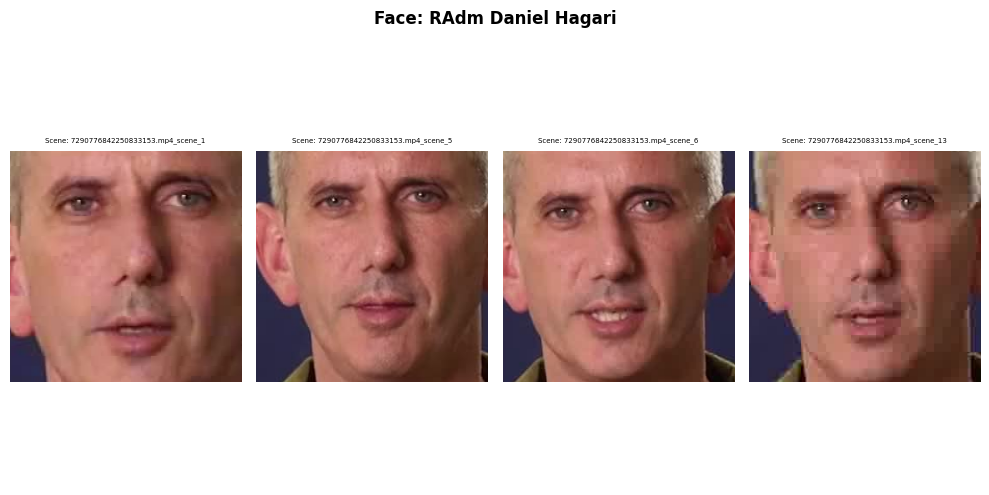

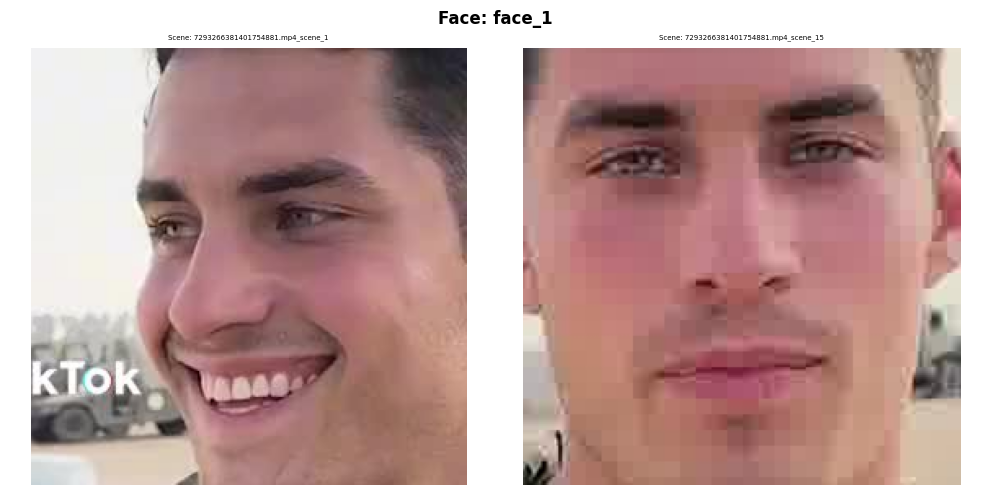

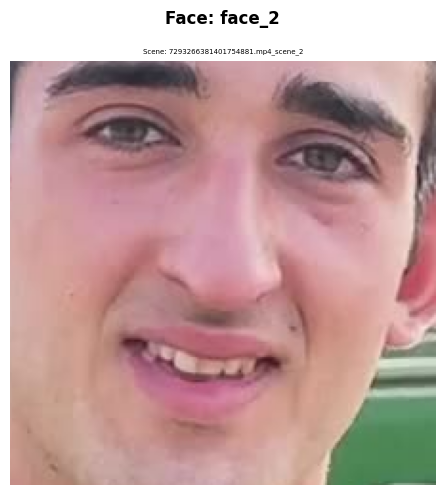

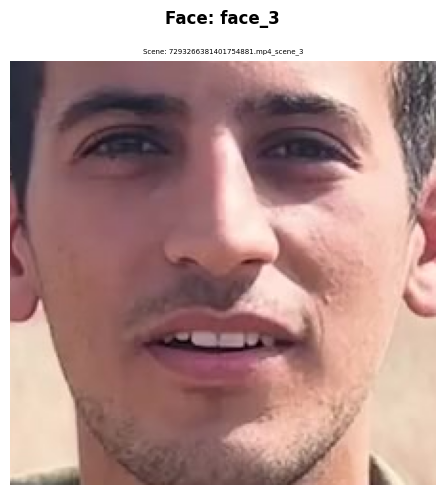

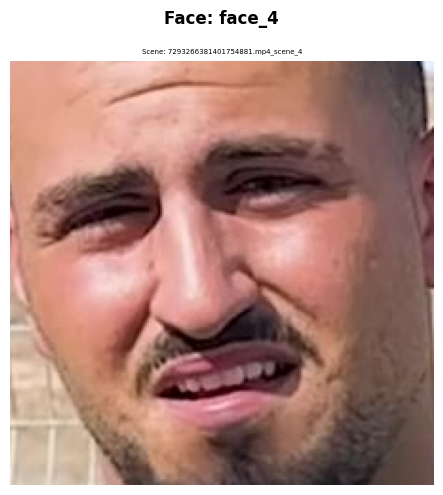

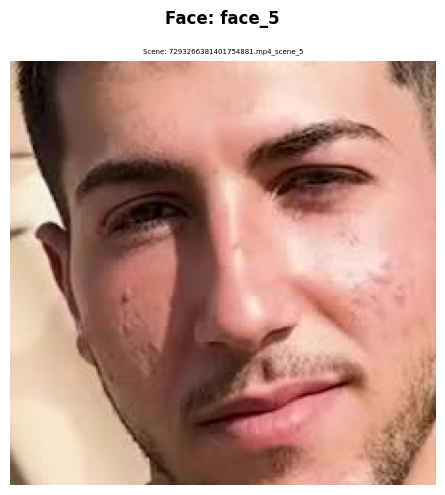

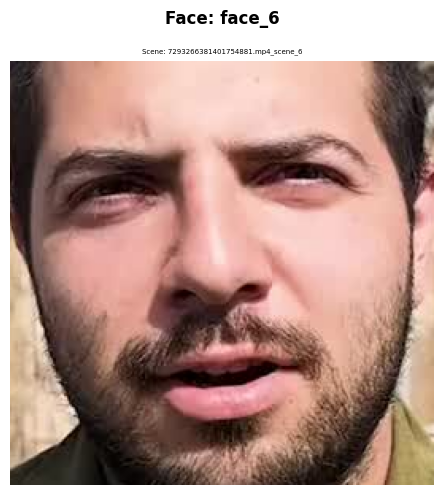

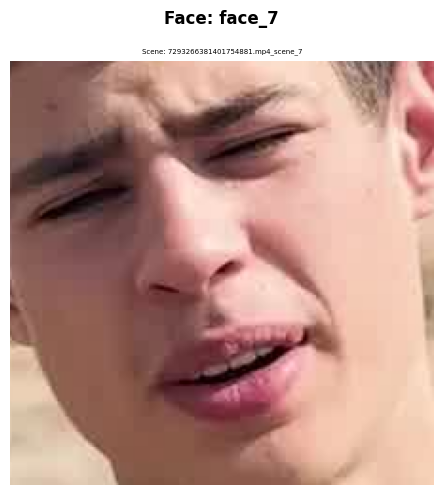

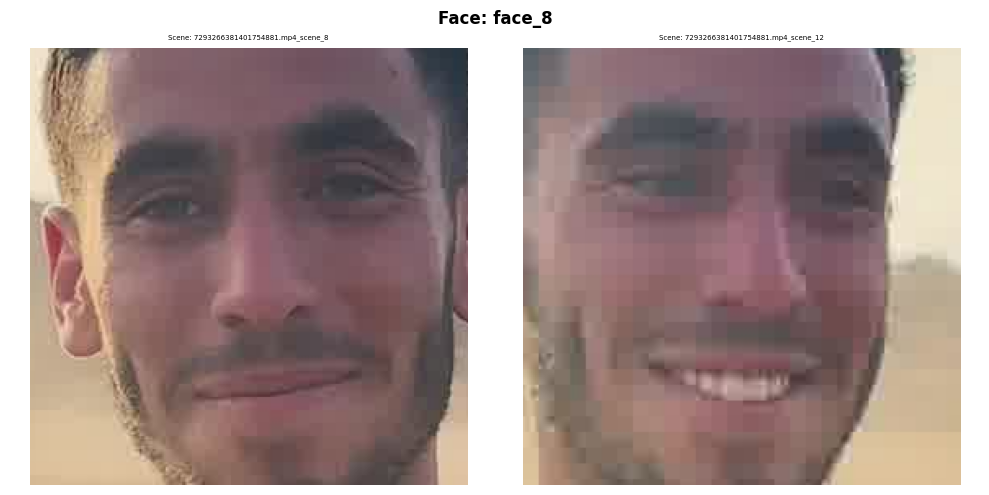

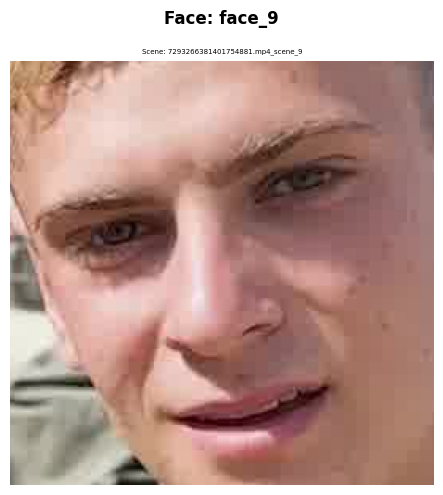

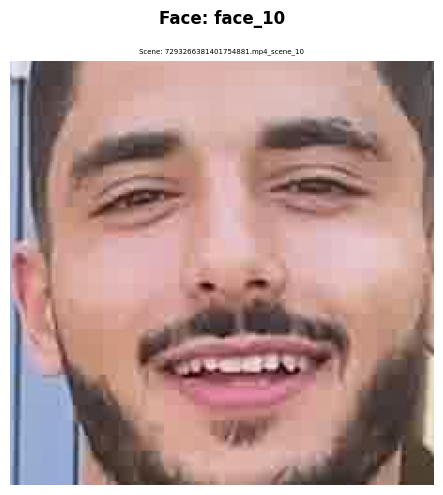

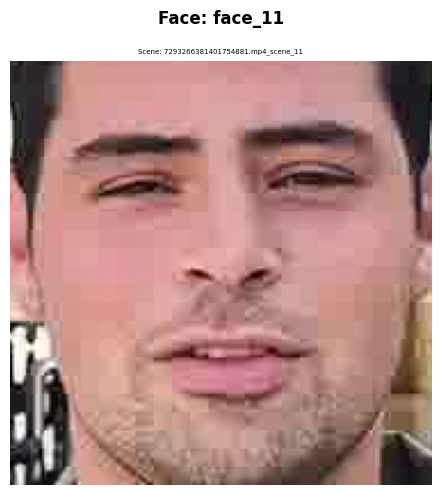

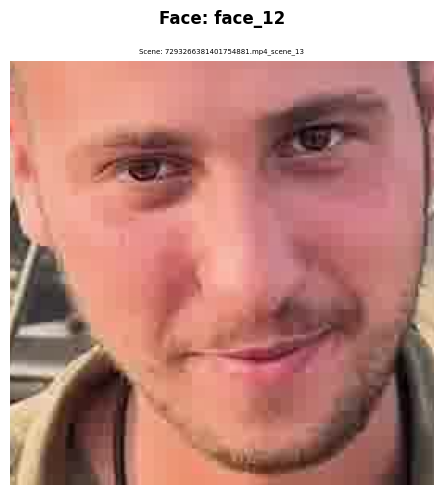

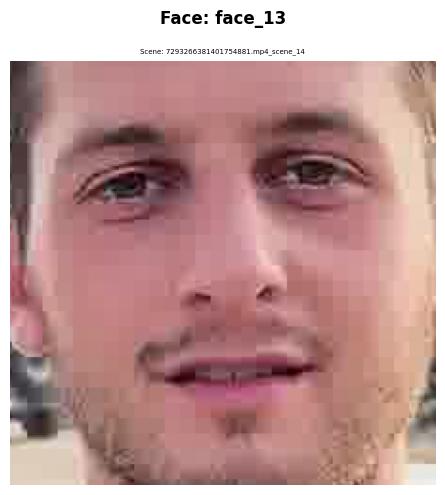

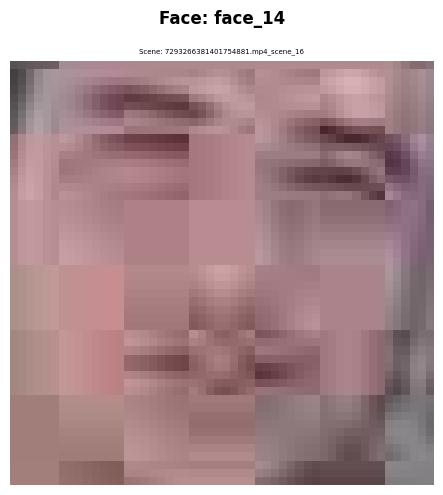

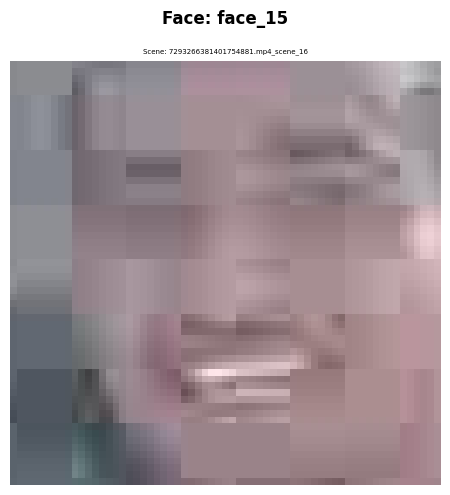

In [81]:
# Visualise faces found in dataset
def viz_face_match(df_faces=df_faces, df_scene=df_scene, frames_folder=frames_folder):
    '''
    :param df_face: dataframe containing face information
    :param df_scene: reference df_scene dataframe
    :return:
    '''

    required_columns = ['face_list', 'face_locations_list']
    if not set(required_columns).issubset(set(df_scene.columns)):
            raise ValueError("The current version of the dataframe lacks facial annotations. Have you run the face recognition processor?")

    for i, face in df_faces.iterrows():

        face_label = face['face_label']
        matched_shots = face['matched_shots']

        plt.figure(figsize=(10, 5))
        plt.suptitle(f'Face: {face_label}', fontsize=12, fontweight='bold')
        plt.axis('off')

        counter = 1
        # Total number of matched shots
        num_shots = len(matched_shots)

        if num_shots == 0:
            print("No matches found") # Shouldn't happen but maybe will need it when we ask for
            return

        for i, matched_shot in enumerate(matched_shots):
            # Filter down main dataset to only contain those that there are identified to match
            matched_shot_data = df_scene[df_scene['id'] == matched_shot]
            plt.subplot(1, num_shots, i + 1)

            video_id = matched_shot_data.iloc[0]['url']
            scene_id = matched_shot_data.iloc[0]['id']
            # scene_id example '7295526580741229825.mp4_scene_1'
            cleaned_id = re.sub(r'\.mp4', '', scene_id)
            # cleaned_id example '7295526580741229825_scene_1'
            # create image path based on video_id
            image_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')

            # Consider that a thumbnail may have multiple faces; Need to match to correct face_label
            # Only matters if we want to crop the faces
            shot_face_list = matched_shot_data.iloc[0]['face_list']
            face_index = shot_face_list.index(face_label)
            # Obtain face_location in shot
            face_locations_list = matched_shot_data.iloc[0]['face_locations_list']
            face_location = face_locations_list[face_index]
            top, right, bottom, left = face_location

            image = face_recognition.load_image_file(image_path)
            face_image = image[top:bottom, left:right]
            plt.imshow(face_image)
            plt.title(f'Scene: {matched_shot}', fontsize=5)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

viz_face_match()

## 2c. Generalized Visual-Language Model (VLM) enabled annotation
Please run the initialisation block, followed by the function ```annotate_vlm(prompt, column_name, model_name', df_scene, frames_folder)``` as suggested below.

*Prepared by Mike Chow*

### Initialize functions for VLM Annotation

In [ ]:
!pip install lmstudio
import lmstudio as lms

In [122]:
def get_qwen_prediction(image_path, prompt, model_name):
    '''
    :param image_path: (str) path to the image file.
    :param prompt: (str) prompt to be used for the model.
    :return: prediction
    '''
    # Check file validity
    # Valid image file extensions
    valid_extensions = ('.jpg', '.jpeg', '.png', '.webp')

    # Valid file extension check
    if not image_path.lower().endswith(valid_extensions):
        raise ValueError(f"Invalid file extension: {image_path}. Supported extensions are {valid_extensions}")

    # File existence check
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"File not found: {image_path}")

    # Check prompt validity
    if not isinstance(prompt, str):
        raise TypeError(f"The prompt must be a string, but got {type(prompt)}")
    if not prompt.strip():  # Empty or whitespace-only prompt
        raise ValueError("The prompt cannot be empty or whitespace. Please provide a valid prompt.")

    image_handle = lms.prepare_image(image_path)  # Convert to image_handle

    model = lms.llm(model_name)
    chat = lms.Chat()
    chat.add_user_message(prompt, images=[image_handle])
    try:
        prediction = model.respond(chat)
    except Exception as e:
        # Handle any exception that might occur during prompting
        raise RuntimeError(f"An error occurred during prompting: {str(e)}")

    # Regex to extract file name
    match = re.search(r'[^/]+$', image_path)
    if match:
        image_name = match.group()
        print(f'Prediction of {image_name}: {prediction.content}')  # Output: 7290776842250833153_scene_1.jpeg
    else:
        print("Error in obtaining file name.")

    return prediction.content

def get_qwen_prediction_batch(df_scene, frames_folder, prompt, column_name, model_name):

    '''
    :param df_scene: dataframe object; Video scene data as generated by 4CAT
    :param frames_folder: file path str; Target folder path where the scene thumbnails are stored
    :param prompt: str; Prompt to be used by the Qwen model
    :param column_name: str;Name of the new column to be added to the dataframe
    :param model_name: str; Name of VLM to be used
    :return: df_scene: dataframe object; Updated dataframe with the Qwen predictions
    '''

    id_list = df_scene['url'].unique().tolist()

    # Loop through list of videos
    for video_id in id_list:
        # video_id example: '7295526580741229825'
        df_scenes = df_scene[df_scene['url'] == video_id]
        scene_list = df_scenes['id'] # Obtain list of scene ids in a video
        # Loop through scenes in specified video
        for scene_id in scene_list:
            # scene_id example '7295526580741229825.mp4_scene_1'
            cleaned_id = re.sub(r'\.mp4', '', scene_id)
            thumbnail_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')
            print(f'Processing {cleaned_id}.jpeg...')

            prediction = get_qwen_prediction(thumbnail_path, prompt, model_name)

            # Append to new column
            df_scene.loc[df_scene['id'] == scene_id, column_name] = prediction

    return df_scene


In [123]:
def annotate_vlm(prompt, column_name, model_name='qwen2-vl-7b-instruct', df_scene=df_scene, frames_folder=frames_folder):
    """
    Takes a specified vision-language model and prompt to analyze video thumbnails and updates the main scene metadata. Requires local developer server of LM Studio to be running with the desired model loaded. See https://lmstudio.ai/docs/app/api for more details.

    :param prompt: A string containing the text instruction for the vision-language model.
    :param column_name: The name of the column in the dataframe where predictions will be
        stored.
    :param model_name: Optional; name of the vision-language model to be used.
        Default is 'qwen2-vl-7b-instruct'.
    :param df_scene: A pandas dataframe containing the input data to be annotated.
    :param frames_folder: Directory path where the input frame files are located.
    :return: None
    """

    if model_name == '':
        model_name = 'qwen2-vl-7b-instruct'

    print(f'Prompting model \'{model_name}\' on LM Studio...')
    df_scene = get_qwen_prediction_batch(df_scene=df_scene,
                                         frames_folder=frames_folder,
                                         prompt=prompt,
                                         column_name=column_name,
                                         model_name=model_name
                                         ) # Reassign as needed; formatted it this way to avoid it being messed up by the order
    print()
    scene_data_path = os.path.join(output_dir, "updated_scene_data.csv")
    df_scene.to_csv(scene_data_path, index=False)
    print("Updated scene data saved to:", scene_data_path)
    print('Done!')
    return df_scene

### VLM-enabled annotation processor ```annotate_vlm()```
```annotate_vlm()``` is a function that takes a specified vision-language model and prompt to analyze video thumbnails and updates the main scene metadata.

**REQUIREMENTS**
Requires local developer server of LM Studio to be running with the desired model loaded. See https://lmstudio.ai/docs/app/api for more details.




**Optional Parameters**
- ```df_faces``` - Dataframe of faces found in the dataset; Defaults to ```df_faces```
- ```df_scene``` - Main scene dataframe; Defaults to the variable ```df_scene```
- ```frames_folder``` - Folder path of thumbnails; Defaults to the variable ```THUMBNAIL_PATH```


In [125]:
prompt = "Your job is to recognize the person and gender in the image. If you cannot identify any person, return 'na'. If you can identify people in the image, return their gender in list form (eg '[M, F]'). If you are uncertain of their gender, return 'unknown'. "

column_name = "gender"

df_scene = annotate_vlm(prompt = prompt,
             column_name=column_name,
             model_name='qwen2-vl-7b-instruct',
             df_scene=df_scene,
             frames_folder=frames_folder
             )
# In test runs, 36 thumbnails took 12 minutes to process on a Macbook Pro (2021) M1 (~20s per thumbnail)

Prompting the model qwen2-vl-7b-instruct on LM Studio...
Processing 7295526580741229825_scene_1.jpeg...
Prediction of 7295526580741229825_scene_1.jpeg: unknown
Processing 7295526580741229825_scene_2.jpeg...
Prediction of 7295526580741229825_scene_2.jpeg: unknown
Processing 7295526580741229825_scene_3.jpeg...
Prediction of 7295526580741229825_scene_3.jpeg: unknown
Processing 7295526580741229825_scene_4.jpeg...
Prediction of 7295526580741229825_scene_4.jpeg: unknown
Processing 7295526580741229825_scene_5.jpeg...
Prediction of 7295526580741229825_scene_5.jpeg: unknown
Processing 7293266381401754881_scene_1.jpeg...
Prediction of 7293266381401754881_scene_1.jpeg: [M]
Processing 7293266381401754881_scene_2.jpeg...
Prediction of 7293266381401754881_scene_2.jpeg: [M]
Processing 7293266381401754881_scene_3.jpeg...
Prediction of 7293266381401754881_scene_3.jpeg: [M]
Processing 7293266381401754881_scene_4.jpeg...
Prediction of 7293266381401754881_scene_4.jpeg: [M]
Processing 7293266381401754881_s

In [126]:
# Review updated dataframe
df_scene

id                  url  \
0    7295526580741229825.mp4_scene_1  7295526580741229825   
1    7295526580741229825.mp4_scene_2  7295526580741229825   
2    7295526580741229825.mp4_scene_3  7295526580741229825   
3    7295526580741229825.mp4_scene_4  7295526580741229825   
4    7295526580741229825.mp4_scene_5  7295526580741229825   
5    7293266381401754881.mp4_scene_1  7293266381401754881   
6    7293266381401754881.mp4_scene_2  7293266381401754881   
7    7293266381401754881.mp4_scene_3  7293266381401754881   
8    7293266381401754881.mp4_scene_4  7293266381401754881   
9    7293266381401754881.mp4_scene_5  7293266381401754881   
10   7293266381401754881.mp4_scene_6  7293266381401754881   
11   7293266381401754881.mp4_scene_7  7293266381401754881   
12   7293266381401754881.mp4_scene_8  7293266381401754881   
13   7293266381401754881.mp4_scene_9  7293266381401754881   
14  7293266381401754881.mp4_scene_10  7293266381401754881   
15  7293266381401754881.mp4_scene_11  7293266381401754881   
16  7293266381401754881.mp4_scene_12  7293266381401754881   
17  7293266381401754881.mp4_scene_13  7293266381401754881   
18  7293266381401754881.mp4_scene_14  7293266381401754881   
19  7293266381401754881.mp4_scene_15  7293266381401754881   
20  7293266381401754881.mp4_scene_16  7293266381401754881   
21  7293266381401754881.mp4_scene_17  7293266381401754881   
22  7293266381401754881.mp4_scene_18  7293266381401754881   
23   7290776842250833153.mp4_scene_1  7290776842250833153   
24   7290776842250833153.mp4_scene_2  7290776842250833153   
25   7290776842250833153.mp4_scene_3  7290776842250833153   
26   7290776842250833153.mp4_scene_4  7290776842250833153   
27   7290776842250833153.mp4_scene_5  7290776842250833153   
28   7290776842250833153.mp4_scene_6  7290776842250833153   
29   7290776842250833153.mp4_scene_7  7290776842250833153   
30   7290776842250833153.mp4_scene_8  7290776842250833153   
31   7290776842250833153.mp4_scene_9  7290776842250833153   
32  7290776842250833153.mp4_scene_10  7290776842250833153   
33  7290776842250833153.mp4_scene_11  7290776842250833153   
34  7290776842250833153.mp4_scene_12  7290776842250833153   
35  7290776842250833153.mp4_scene_13  7290776842250833153   

                        from_dataset  start_frame             start_time  \
0   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
1   2765e716c4281cfa216dae395b39560c           50        0 days 00:00:02   
2   2765e716c4281cfa216dae395b39560c          100        0 days 00:00:04   
3   2765e716c4281cfa216dae395b39560c          150        0 days 00:00:06   
4   2765e716c4281cfa216dae395b39560c          200        0 days 00:00:08   
5   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
6   2765e716c4281cfa216dae395b39560c           43 0 days 00:00:01.433000   
7   2765e716c4281cfa216dae395b39560c           74 0 days 00:00:02.467000   
8   2765e716c4281cfa216dae395b39560c          107 0 days 00:00:03.567000   
9   2765e716c4281cfa216dae395b39560c          142 0 days 00:00:04.733000   
10  2765e716c4281cfa216dae395b39560c          176 0 days 00:00:05.867000   
11  2765e716c4281cfa216dae395b39560c          205 0 days 00:00:06.833000   
12  2765e716c4281cfa216dae395b39560c          239 0 days 00:00:07.967000   
13  2765e716c4281cfa216dae395b39560c          275 0 days 00:00:09.167000   
14  2765e716c4281cfa216dae395b39560c          314 0 days 00:00:10.467000   
15  2765e716c4281cfa216dae395b39560c          361 0 days 00:00:12.033000   
16  2765e716c4281cfa216dae395b39560c          389 0 days 00:00:12.967000   
17  2765e716c4281cfa216dae395b39560c          417 0 days 00:00:13.900000   
18  2765e716c4281cfa216dae395b39560c          447 0 days 00:00:14.900000   
19  2765e716c4281cfa216dae395b39560c          487 0 days 00:00:16.233000   
20  2765e716c4281cfa216dae395b39560c          517 0 days 00:00:17.233000   
21  2765e716c4281cfa216dae395b39560c          547 0 days 00:00:18.233000   
22  2765e716c4281cfa216dae39

### Visualise Predictions alongside thumbnails

```viz_vlm_results()``` is a function that visualizes the results of VLM annotation and displays them next to the shot for review

**Parameters**
```target_column``` - Desired column to be reviewed

**Optional Parameters**
- ```df_scene``` - Main scene dataframe; Defaults to the variable ```df_scene```
- ```frames_folder``` - Folder path of thumbnails; Defaults to the variable ```THUMBNAIL_PATH```

In [171]:
def viz_vlm_results(target_column, df_scene=df_scene, frames_folder=frames_folder):
    """
    Visualizes Visual Language Model (VLM) prediction results for specific video scenes by
    displaying thumbnails with associated annotations contained in the target column.

    :param target_column: The name of the column in the dataframe 'df_scene'
                          used as the annotation for thumbnails.
    :type target_column: str
    :param df_scene: DataFrame containing the video URLs, scene IDs, and related information.
    :type df_scene: pandas.DataFrame
    :param frames_folder: Folder path where thumbnail image files for each scene are stored.
                          Image files are expected to follow a specific naming convention.
                          Defaults to `frames_folder`.
    :type frames_folder: str
    :return: None. The function creates and shows visualizations for the given video(s)
             and their corresponding scenes.
    :rtype: None
    """

    # Check for the correct dataframe
    if not target_column in df_scene.columns:
            raise ValueError("The dataframe lacks the desired target column. Please check again.")

    # Visualize by video
    video_list = df_scene['url'].unique()
    # Set maximum thumbnails per row to prevent overcrowding
    max_row_len = 10

    for video in video_list:
        df_scene_for_vid = df_scene[df_scene['url'] == video].reset_index(drop=True)
        num_scenes = len(df_scene_for_vid)
        video_id = df_scene_for_vid.iloc[0]['url']

        num_rows = num_scenes // max_row_len + 1 # Ceiling division to calculate number of rows
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"VLM Predictions for shot thumbnails in {video_id} for column \'{target_column}\'", fontsize=12)

        plt.axis('off')


        # Loop through scenes in video
        for i, scene in df_scene_for_vid.iterrows():
            scene_id = scene['id']
            # scene_id example '7295526580741229825.mp4_scene_1'
            cleaned_id = re.sub(r'\.mp4', '', scene_id)
            # cleaned_id example '7295526580741229825_scene_1'
            # create image path based on video_id
            image_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')

            image = face_recognition.load_image_file(image_path)

            # Display image
            if num_scenes > max_row_len:
                plt.subplot(num_rows, max_row_len, i+1)
            else:
                plt.subplot(1, num_scenes, i+1)

            plt.title(f"Annotation for scene {scene['scene_num']}: \n{scene[target_column]}", fontsize=5)
            plt.imshow(image)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

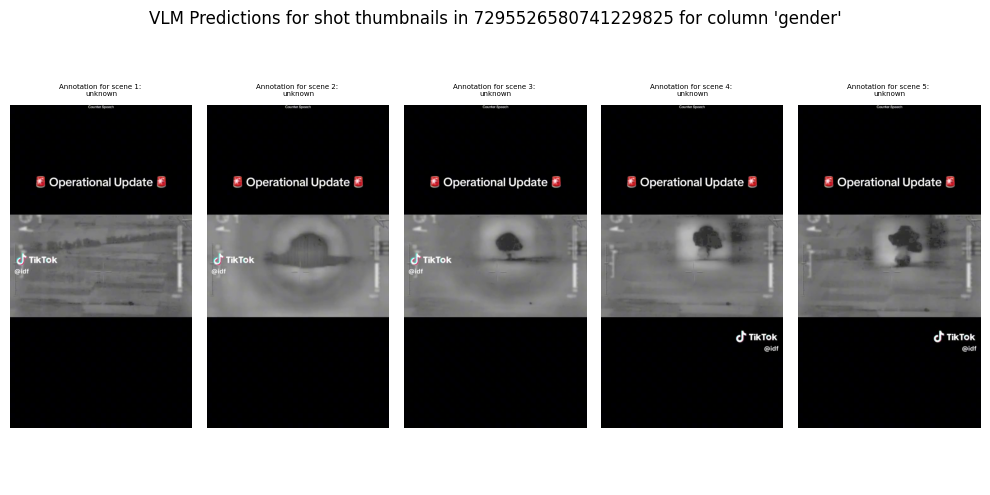

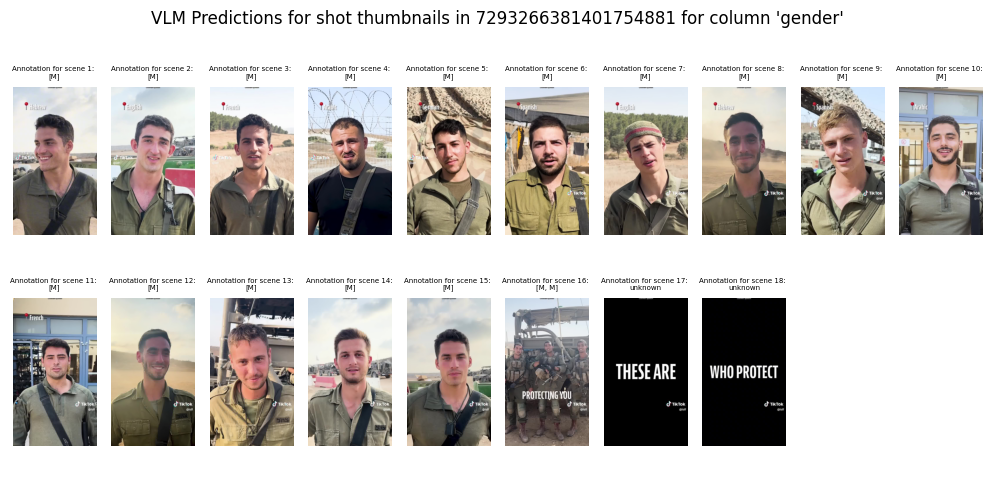

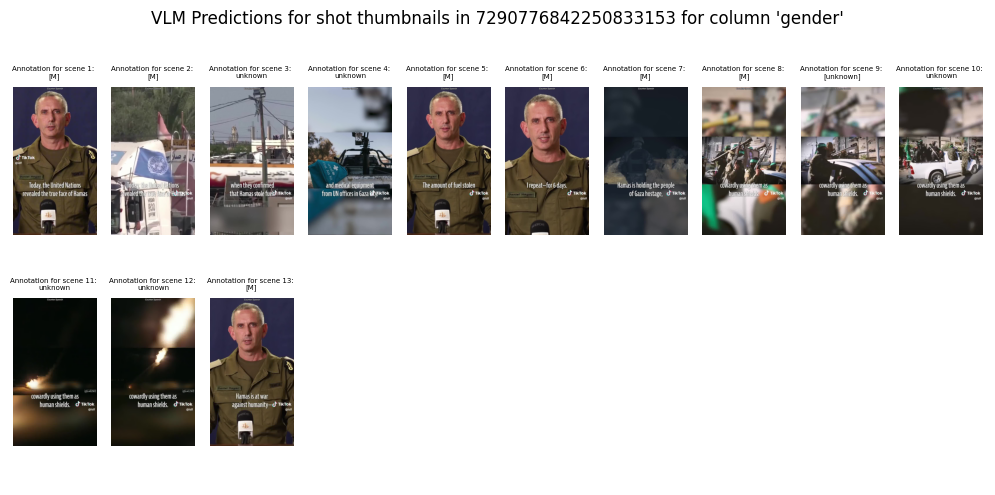

In [172]:
viz_vlm_results('gender')

# 3. Visualisation and Gathering Insights

## General Timeline Visualisations
These functions generate timeline visualisations that are agnostic to the feature category. This means that they generate the same types of graph regardless of the desired ```target_column```. This is particularly useful if you ran ```annotate_vlm()```For more bespoke timeline visualisations specific to an annotation processor (such as annotations), please scroll further below.

### ```viz_timeline()``` Standard Timeline Visualization
This visualization function generates a processor-agnostic timeline chart as a timeline. A ```target_column``` can be defined to color code shots based on the unique categories found in the column. ```mode``` can be chosen between ```abs``` (absolute) or ```rel``` (relative) to select the type of visualization

**Parameters:**

```mode``` - Either ```abs``` (absolute) or ```rel``` (relative); ```abs``` displays timelines in their original duration whereas ```rel``` will normalize the duration of all videos. Defaults to ```abs```

```df_scene``` - Dataframe containing scene metadata; Defaults to ```df_scene```

```target_column``` - A threshold to filter the count face matches (default is 0) to avoid generating undesired color noise. If a face is found in the dataset less times than the match_threshold, it will be grouped as 'Others'

In [260]:
def viz_timeline(mode="abs", target_column = "", df_scene=df_scene):
    """
    Generate a timeline visualizations for a dataset of videos.
    :param mode: Either "abs" or "rel" to set the timeline visualization either as absolute (displays original duration) or relative (every video will have their timeline normalized)
    :param target_column: name of column to be used to color code shots; Can be left blank for random colors
    :type target_column: str
    :param df_scene: Dataframe containing scene metadata

    """

    # Validate the mode parameter
    if mode not in ["abs", "rel"]:
        print(f"Invalid mode '{mode}' provided. Defaulting to 'abs' (Absolute time visualization).")
        mode = "abs"

    if target_column:
        if not target_column in df_scene.columns:
                raise ValueError("The current version of the dataframe lacks the target column for color coding. Please try again. ")

        # Unique annotations in column
        annotation_list = df_scene[target_column].unique()

        # Assign colour based on unique values in the column
        # Initialize color mapping
        label_to_color = {}

        for i, label in enumerate(annotation_list):
                # Assign a random color from the rainbow colormap for other unique faces
                label_to_color[label] = plt.cm.rainbow(i / len(annotation_list))

    # Extract unique video IDs from scene_data
    unique_ids = df_scene['url'].unique()

    fig, ax = plt.subplots(figsize=(10, 2.5 * len(unique_ids)))

    y_offset = 0

    # Loop through every video
    for video_id in unique_ids:
        # Filter scenes from the current video ID
        df_sub_scenes = df_scene[df_scene['url'] == video_id].reset_index(drop=True)
        total_duration = df_sub_scenes.iloc[0]['total_video_duration']

        if not target_column: # Assign random colors to shots for readability if no target_column is defined
            # Create a colourmap with appropriate number of colours based on number of shots
            num_shots = len(df_sub_scenes)
            colourmap = plt.get_cmap('rainbow', num_shots)
        # Loop over all scenes from the current video ID
        for i, scene in df_sub_scenes.iterrows():

            start_time = scene['start_time'].total_seconds()
            end_time = scene['end_time'].total_seconds()
            duration = end_time - start_time

            # If mode set to relative, normalize the durations
            if mode == "rel":
                start_time = start_time / total_duration.total_seconds() * 100
                duration = duration / total_duration.total_seconds() * 100

            if target_column: # If there is a desired column for color coding
                annotation = scene[target_column]
                # Assign colors for annotations in target column and draw rect
                if annotation:
                    color = label_to_color.get(annotation, 'black')  # Default to black if no label match somehow

                    rect = plt.Rectangle((start_time, y_offset), duration, 1, edgecolor='black', facecolor=color, lw=1)
                    ax.add_patch(rect)
                else:
                    # If somehow there's an invalid entry, use light gray as a default color
                    rect = plt.Rectangle((start_time, y_offset), duration, 1, edgecolor='black', facecolor='lightgray', lw=1)
                    ax.add_patch(rect)
            else: # If there is no target column for color coding
                color = colourmap(i)
                rect = patches.Rectangle((start_time, y_offset), duration, 1, linewidth=1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)

        # Field to add annotations if necessary
        if mode == "rel":
            ax.text(
                100 + 2,
                y_offset + 0.5,
                f"Duration of video: {total_duration.total_seconds()}s",
                ha='left', va='center'
            )

        print(f'Processed video {video_id}, total duration: {total_duration.total_seconds()}s')

        y_offset += 1.5  # Increment for next video

    # Set axis details
    if mode == "rel":
        ax.set_xlim(0, 100)
        ax.set_xlabel("Video Duration (%)")
        ax.set_title("Normalized Video Timelines by Shots")
    elif mode == "abs":
        ax.set_xlim(0,max(df_scene['total_video_duration'].dt.total_seconds()))
        ax.set_xlabel('Time (in seconds)')
        ax.set_title("Video Timelines by Shots")

    ax.set_ylim(0, y_offset)
    ax.set_yticks(np.arange(0.75, y_offset, 1.5))
    ax.set_yticklabels(unique_ids)
    plt.tight_layout()

    # Add legend for the colors if target column is defined
    if target_column:
        legend_handles = [
            plt.Line2D([0], [0], color=color, lw=4, label=label)
            for label, color in label_to_color.items()
        ]

        # Place the legend below the graph, centered
        ax.legend(
            handles=legend_handles,
            title='Legend',
            loc='lower center',
            bbox_to_anchor=(0.5, -0.3),  # Center the legend below the graph
            ncol=4,  # Adjust columns based on labels for better spacing
            frameon=True
        )

    plt.show()

In [261]:
# Create a copy of df_scene
df_scene_copy = df_scene.copy()

# Randomly assign numbers from 1 to 5 to a new column for demonstration
df_scene_copy["random_numbers"] = np.random.choice(range(1, 6), size=len(df_scene))
df_scene_copy

id                  url  \
0    7295526580741229825.mp4_scene_1  7295526580741229825   
1    7295526580741229825.mp4_scene_2  7295526580741229825   
2    7295526580741229825.mp4_scene_3  7295526580741229825   
3    7295526580741229825.mp4_scene_4  7295526580741229825   
4    7295526580741229825.mp4_scene_5  7295526580741229825   
5    7293266381401754881.mp4_scene_1  7293266381401754881   
6    7293266381401754881.mp4_scene_2  7293266381401754881   
7    7293266381401754881.mp4_scene_3  7293266381401754881   
8    7293266381401754881.mp4_scene_4  7293266381401754881   
9    7293266381401754881.mp4_scene_5  7293266381401754881   
10   7293266381401754881.mp4_scene_6  7293266381401754881   
11   7293266381401754881.mp4_scene_7  7293266381401754881   
12   7293266381401754881.mp4_scene_8  7293266381401754881   
13   7293266381401754881.mp4_scene_9  7293266381401754881   
14  7293266381401754881.mp4_scene_10  7293266381401754881   
15  7293266381401754881.mp4_scene_11  7293266381401754881   
16  7293266381401754881.mp4_scene_12  7293266381401754881   
17  7293266381401754881.mp4_scene_13  7293266381401754881   
18  7293266381401754881.mp4_scene_14  7293266381401754881   
19  7293266381401754881.mp4_scene_15  7293266381401754881   
20  7293266381401754881.mp4_scene_16  7293266381401754881   
21  7293266381401754881.mp4_scene_17  7293266381401754881   
22  7293266381401754881.mp4_scene_18  7293266381401754881   
23   7290776842250833153.mp4_scene_1  7290776842250833153   
24   7290776842250833153.mp4_scene_2  7290776842250833153   
25   7290776842250833153.mp4_scene_3  7290776842250833153   
26   7290776842250833153.mp4_scene_4  7290776842250833153   
27   7290776842250833153.mp4_scene_5  7290776842250833153   
28   7290776842250833153.mp4_scene_6  7290776842250833153   
29   7290776842250833153.mp4_scene_7  7290776842250833153   
30   7290776842250833153.mp4_scene_8  7290776842250833153   
31   7290776842250833153.mp4_scene_9  7290776842250833153   
32  7290776842250833153.mp4_scene_10  7290776842250833153   
33  7290776842250833153.mp4_scene_11  7290776842250833153   
34  7290776842250833153.mp4_scene_12  7290776842250833153   
35  7290776842250833153.mp4_scene_13  7290776842250833153   

                        from_dataset  start_frame             start_time  \
0   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
1   2765e716c4281cfa216dae395b39560c           50        0 days 00:00:02   
2   2765e716c4281cfa216dae395b39560c          100        0 days 00:00:04   
3   2765e716c4281cfa216dae395b39560c          150        0 days 00:00:06   
4   2765e716c4281cfa216dae395b39560c          200        0 days 00:00:08   
5   2765e716c4281cfa216dae395b39560c            0        0 days 00:00:00   
6   2765e716c4281cfa216dae395b39560c           43 0 days 00:00:01.433000   
7   2765e716c4281cfa216dae395b39560c           74 0 days 00:00:02.467000   
8   2765e716c4281cfa216dae395b39560c          107 0 days 00:00:03.567000   
9   2765e716c4281cfa216dae395b39560c          142 0 days 00:00:04.733000   
10  2765e716c4281cfa216dae395b39560c          176 0 days 00:00:05.867000   
11  2765e716c4281cfa216dae395b39560c          205 0 days 00:00:06.833000   
12  2765e716c4281cfa216dae395b39560c          239 0 days 00:00:07.967000   
13  2765e716c4281cfa216dae395b39560c          275 0 days 00:00:09.167000   
14  2765e716c4281cfa216dae395b39560c          314 0 days 00:00:10.467000   
15  2765e716c4281cfa216dae395b39560c          361 0 days 00:00:12.033000   
16  2765e716c4281cfa216dae395b39560c          389 0 days 00:00:12.967000   
17  2765e716c4281cfa216dae395b39560c          417 0 days 00:00:13.900000   
18  2765e716c4281cfa216dae395b39560c          447 0 days 00:00:14.900000   
19  2765e716c4281cfa216dae395b39560c          487 0 days 00:00:16.233000   
20  2765e716c4281cfa216dae395b39560c          517 0 days 00:00:17.233000   
21  2765e716c4281cfa216dae395b39560c          547 0 days 00:00:18.233000   
22  2765e716c4281cfa216dae39

Processed video 7295526580741229825, total duration: 8.88s
Processed video 7293266381401754881, total duration: 21.6s
Processed video 7290776842250833153, total duration: 48.715s


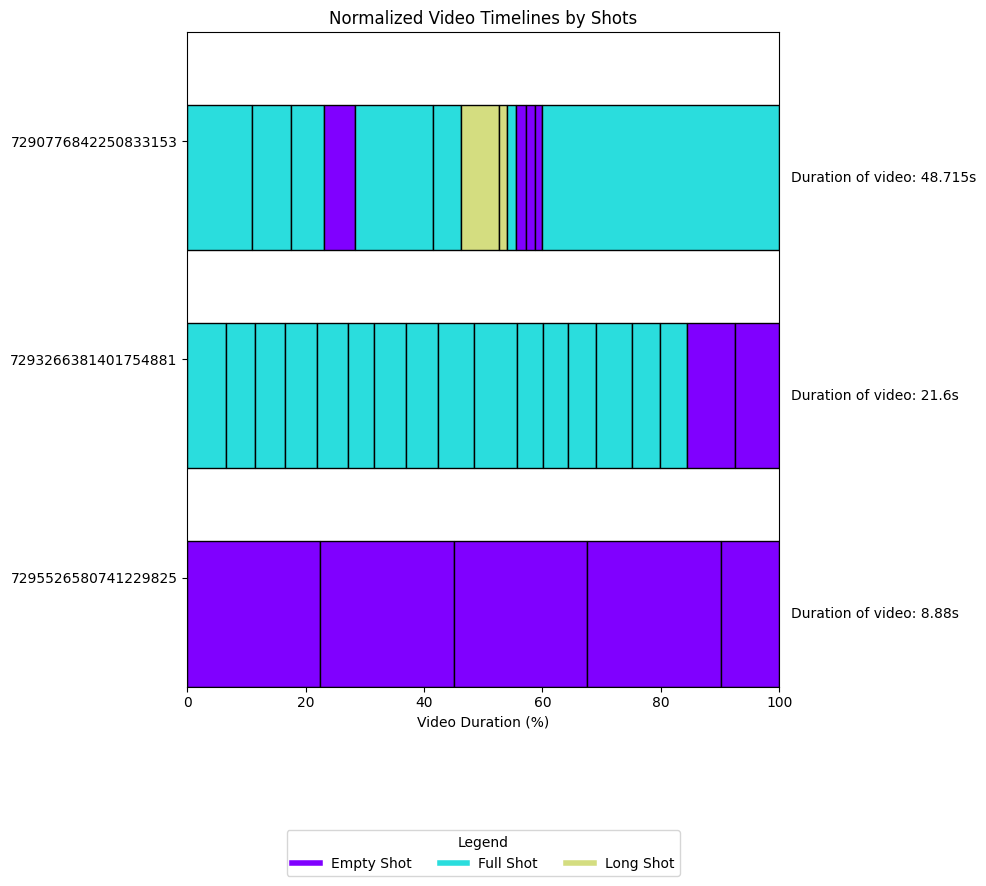

In [263]:
viz_timeline(mode = "rel", df_scene = df_scene_copy, target_column="shot_scale")

### ```viz_timeline_stripe()``` Stripe Timeline Visualization for Macro-viewing
This visualization function generates a processor-agnostic timeline chart as a timeline. A ```target_column``` can be defined to color code shots based on the unique categories found in the column. ```mode``` can be chosen between ```abs``` (absolute) or ```rel``` (relative) to select the type of visualization

**Parameters:**

```mode``` - Either ```abs``` (absolute) or ```rel``` (relative); ```abs``` displays timelines in their original duration whereas ```rel``` will normalize the duration of all videos. Defaults to ```abs```

```df_scene``` - Dataframe containing scene metadata; Defaults to ```df_scene```

```target_column``` - A threshold to filter the count face matches (default is 0) to avoid generating undesired color noise. If a face is found in the dataset less times than the match_threshold, it will be grouped as 'Others'

In [314]:
def viz_timeline_stripe(mode="abs", target_column = "", df_scene=df_scene, stripe_height=0.05):
    """
    Generate a timeline visualizations for a dataset of videos in thin stripes for the purposes of macro-viewing.

    :param mode: Either "abs" or "rel" to set the timeline visualization either as absolute (displays original duration) or relative (every video will have their timeline normalized)
    :param target_column: name of column to be used to color code shots; Can be left blank for random colors
    :type target_column: str
    :param df_scene: Dataframe containing scene metadata
    :param stripe_height: Modifies the height of the stripes

    """

    # Validate the mode parameter
    if mode not in ["abs", "rel"]:
        print(f"Invalid mode '{mode}' provided. Defaulting to 'abs' (Absolute time visualization).")
        mode = "abs"

    if target_column:
        if not target_column in df_scene.columns:
                raise ValueError("The current version of the dataframe lacks the target column for color coding. Please try again. ")

        # Unique annotations in column
        annotation_list = df_scene[target_column].unique()

        # Assign colour based on unique values in the column
        # Initialize color mapping
        label_to_color = {}

        for i, label in enumerate(annotation_list):
                # Assign a random color from the rainbow colormap for other unique faces
                label_to_color[label] = plt.cm.rainbow(i / len(annotation_list))

    # Extract unique video IDs from scene_data
    unique_ids = df_scene['url'].unique()

    fig_height = (len(unique_ids) * stripe_height)
    fig, ax = plt.subplots(figsize=(10, fig_height))


    # Loop through every video
    for i, video_id in enumerate(unique_ids):
        y_offset = i * stripe_height
        # Filter scenes from the current video ID
        df_sub_scenes = df_scene[df_scene['url'] == video_id].reset_index(drop=True)
        total_duration = df_sub_scenes.iloc[0]['total_video_duration']

        if not target_column: # Assign random colors to shots for readability if no target_column is defined
            # Create a colourmap with appropriate number of colours based on number of shots
            num_shots = len(df_sub_scenes)
            colourmap = plt.get_cmap('rainbow', num_shots)
        # Loop over all scenes from the current video ID
        for i, scene in df_sub_scenes.iterrows():

            start_time = scene['start_time'].total_seconds()
            end_time = scene['end_time'].total_seconds()
            duration = end_time - start_time

            # If mode set to relative, normalize the durations
            if mode == "rel":
                start_time = start_time / total_duration.total_seconds() * 100
                duration = duration / total_duration.total_seconds() * 100

            if target_column: # If there is a desired column for color coding
                annotation = scene[target_column]
                # Assign colors for annotations in target column and draw rect
                if annotation:
                    color = label_to_color.get(annotation, 'black')  # Default to black if no label match somehow

                    rect = plt.Rectangle((start_time, y_offset), duration, stripe_height, edgecolor='black', facecolor=color, lw=1)
                    ax.add_patch(rect)
                else:
                    # If somehow there's an invalid entry, use light gray as a default color
                    rect = plt.Rectangle((start_time, y_offset), duration, stripe_height, edgecolor='black', facecolor='lightgray', lw=1)
                    ax.add_patch(rect)
            else: # If there is no target column for color coding
                color = colourmap(i)
                rect = patches.Rectangle((start_time, y_offset), duration, stripe_height, linewidth=1, edgecolor='black', facecolor=color)
                ax.add_patch(rect)

        print(f'Processed video {video_id}, total duration: {total_duration.total_seconds()}s')

    # Set axis details
    if mode == "rel":
        ax.set_xlim(0, 100)
        ax.set_xlabel("Video Duration (%)")
        ax.set_title(f"Overview of dataset color coded by {target_column}")
    elif mode == "abs":
        ax.set_xlim(0,max(df_scene['total_video_duration'].dt.total_seconds()))
        ax.set_xlabel('Time (in seconds)')
        ax.set_title("Video Timelines by Shots")

    ax.set_ylim(0, len(unique_ids) * stripe_height)
    ax.yaxis.set_visible(False) # Turn off y ticks

    # Add legend for the colors if target column is defined
    if target_column:
        legend_handles = [
            plt.Line2D([0], [0], color=color, lw=4, label=label)
            for label, color in label_to_color.items()
        ]

        # Place the legend (Optional))
        ax.legend(
            handles=legend_handles,
            title='Legend',
            loc='upper right',
            bbox_to_anchor=(1.2, 1.1),
            ncol=1,  # Adjust columns based on labels for better spacing
            frameon=False
        )

    plt.show()


Processed video 7295526580741229825, total duration: 8.88s
Processed video 7293266381401754881, total duration: 21.6s
Processed video 7290776842250833153, total duration: 48.715s


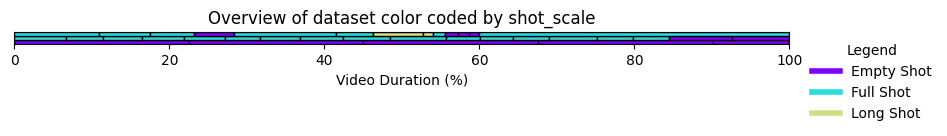

In [315]:
viz_timeline_stripe(mode="rel",target_column="shot_scale", stripe_height=0.05)

Processed video 7295526580741229825, total duration: 8.88s
Processed video 7293266381401754881, total duration: 21.6s
Processed video 7290776842250833153, total duration: 48.715s


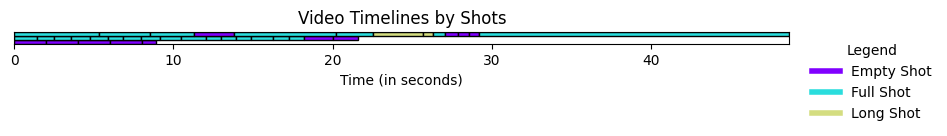

In [316]:
viz_timeline_stripe(mode="abs",target_column="shot_scale", stripe_height=0.05)


## Processor Specific Timeline Visualization

### ```viz_timeline_shotscale()``` Timeline Visualizations for shot scale

This visualization function is developed specifically for visualise shot scale annotations as a timeline.

**Parameters:**

```mode``` - Either ```abs``` (absolute) or ```rel``` (relative); ```abs``` displays timelines in their original duration whereas ```rel``` will normalize the duration of all videos. Defaults to ```abs```

```df_scene``` - Dataframe containing scene metadata; Defaults to ```df_scene```

In [273]:
# Visualization function
def viz_timeline_shotscale(mode="abs", df_scene=df_scene):

    required_columns = ['shot_scale']
    if not set(required_columns).issubset(set(df_scene.columns)):
            raise ValueError("The current version of the dataframe lacks shot_scale annotations. Have you run the shot scale processor?")

    # Validate the mode parameter
    if mode not in ["abs", "rel"]:
        print(f"Invalid mode '{mode}' provided. Defaulting to 'abs' (Absolute time visualization).")
        mode = "abs"

    # Color Scheme
    SHOT_SCALE_COLORS = {
    'Close-Up': '#ff4500',
    'Medium Close-Up': '#ffa500',
    'Medium Shot': '#f0e68c',
    'Full Shot': '#4682b4',
    'Long Shot': '#4169e1',
    'Empty Shot': '#d3d3d3'
}

    all_shots = []
    grouped = df_scene.groupby("url") # Group shots by video IDs

    for video_id, group in grouped:
        max_time = group["total_video_duration"].max().total_seconds()
        if pd.isna(max_time) or max_time == 0:
            continue

        # Loops through dataframe to collect relevant data
        for _, row in group.iterrows():
            start_time = row["start_time"].total_seconds()
            end_time = row["end_time"].total_seconds()
            duration = end_time - start_time
            scale = row["shot_scale"]

            # If mode set to relative, normalize the durations
            if mode == "rel":
                start_time = start_time / max_time * 100
                duration = duration / max_time * 100

            all_shots.append((video_id, scale, start_time, duration))
    if not all_shots:
        print("No valid shot scale data to visualize.")
        return

    # Plot
    video_ids = sorted(set(x[0] for x in all_shots))
    video_to_y = {vid: idx for idx, vid in enumerate(video_ids)}

    fig, ax = plt.subplots(figsize=(12, len(video_ids) * 0.6))
    for vid, scale, start, duration in all_shots:
        y = video_to_y[vid]
        color = SHOT_SCALE_COLORS.get(scale, "#999999")
        rect = patches.Rectangle((start, y), duration, 0.8, linewidth=0.3,
                                 edgecolor='black', facecolor=color)
        ax.add_patch(rect)
    if mode == "rel":
        ax.set_xlim(0, 100)
        ax.set_xlabel("Video Duration (%)")
        ax.set_title("Normalized Video Timelines by Shots with Shot Scale Annotations")
    elif mode == "abs":
        ax.set_xlim(0, max(df_scene['total_video_duration'].dt.total_seconds()))
        ax.set_xlabel("Time (in seconds)")
        ax.set_title("Video Timelines by Shots with Shot Scale Annotations")
    ax.set_ylim(-0.5, len(video_ids) - 0.5)
    ax.set_yticks(range(len(video_ids)))
    ax.set_yticklabels(video_ids)

    ax.legend(handles=[
        patches.Patch(color=color, label=scale)
        for scale, color in SHOT_SCALE_COLORS.items()
    ], bbox_to_anchor=(1.01, 1), loc='upper left', title="Shot Scale", fontsize=8)

    plt.tight_layout()
    plt.show()

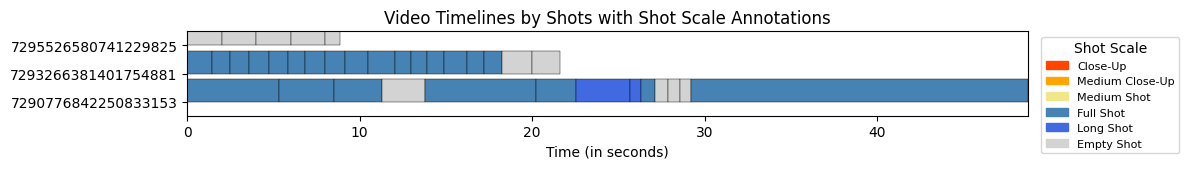

In [274]:
viz_timeline_shotscale(mode="abs")

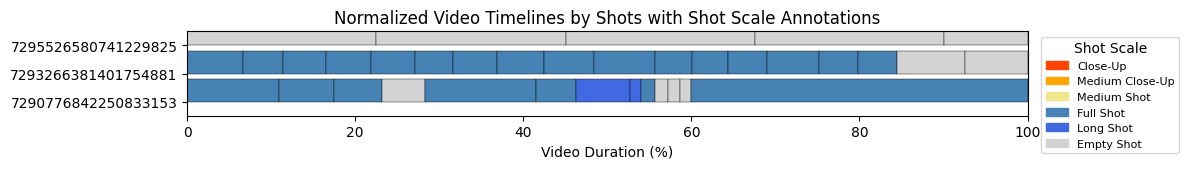

In [275]:
viz_timeline_shotscale(mode="rel")


In [319]:
# Visualization function
def viz_timeline_shotscale_stripe(mode="abs", df_scene=df_scene, stripe_height = 0.03):

    required_columns = ['shot_scale']
    if not set(required_columns).issubset(set(df_scene.columns)):
            raise ValueError("The current version of the dataframe lacks shot_scale annotations. Have you run the shot scale processor?")

    # Validate the mode parameter
    if mode not in ["abs", "rel"]:
        print(f"Invalid mode '{mode}' provided. Defaulting to 'abs' (Absolute time visualization).")
        mode = "abs"

    # Color Scheme
    SHOT_SCALE_COLORS = {
    'Close-Up': '#ff4500',
    'Medium Close-Up': '#ffa500',
    'Medium Shot': '#f0e68c',
    'Full Shot': '#4682b4',
    'Long Shot': '#4169e1',
    'Empty Shot': '#d3d3d3'
}

    all_shots = []
    grouped = df_scene.groupby("url") # Group shots by video IDs

    for video_id, group in grouped:
        max_time = group["total_video_duration"].max().total_seconds()
        if pd.isna(max_time) or max_time == 0:
            continue

        # Loops through dataframe to collect relevant data
        for _, row in group.iterrows():
            start_time = row["start_time"].total_seconds()
            end_time = row["end_time"].total_seconds()
            duration = end_time - start_time
            scale = row["shot_scale"]

            # If mode set to relative, normalize the durations
            if mode == "rel":
                start_time = start_time / max_time * 100
                duration = duration / max_time * 100

            all_shots.append((video_id, scale, start_time, duration))
    if not all_shots:
        print("No valid shot scale data to visualize.")
        return

    # Plot
    video_ids = sorted(set(x[0] for x in all_shots))
    video_to_y = {vid: idx for idx, vid in enumerate(video_ids)}

    fig_height = len(video_ids) * stripe_height
    fig, ax = plt.subplots(figsize=(12, fig_height))

    for vid, scale, start, duration in all_shots:
        y = video_to_y[vid] * stripe_height
        color = SHOT_SCALE_COLORS.get(scale, "#999999")
        rect = patches.Rectangle((start, y), duration, 0.8, linewidth=0.3,
                                 edgecolor='black', facecolor=color)
        ax.add_patch(rect)
    if mode == "rel":
        ax.set_xlim(0, 100)
        ax.set_xlabel("Video Duration (%)")
        ax.set_title("Normalized Video Timelines by Shots with Shot Scale Annotations")
    elif mode == "abs":
        ax.set_xlim(0, max(df_scene['total_video_duration'].dt.total_seconds()))
        ax.set_xlabel("Time (in seconds)")
        ax.set_title("Video Timelines by Shots with Shot Scale Annotations")
    ax.set_ylim(0, len(video_ids) * stripe_height)
    ax.axis("off")

    ax.legend(handles=[
        patches.Patch(color=color, label=scale)
        for scale, color in SHOT_SCALE_COLORS.items()
    ], bbox_to_anchor=(1.01, 1), loc='upper left', title="Shot Scale", fontsize=8)

    plt.tight_layout()
    plt.show()

/var/folders/1m/h9ydjgrj4qx54ls2tt7fffkc0000gn/T/ipykernel_48190/1067742071.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


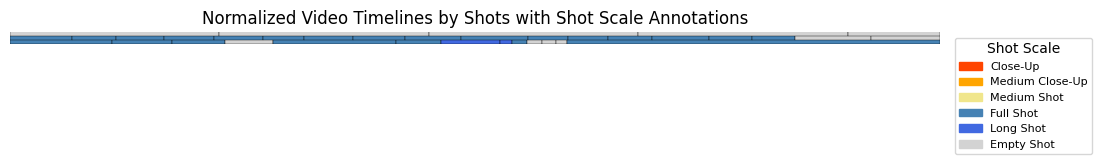

In [321]:
viz_timeline_shotscale_stripe(mode="rel",stripe_height=0.05)

### ```viz_face_timeline()``` - Timeline Visualisations based on identified faces
This visualization function is developed specifically for visualise face recognition annotations as a timeline. This will also add annotations to the chart containing data on the total number of faces found in the video.

**Parameters:**

```mode``` - Either ```abs``` (absolute) or ```rel``` (relative); ```abs``` displays timelines in their original duration whereas ```rel``` will normalize the duration of all videos. Defaults to ```abs```

```df_scene``` - Dataframe containing scene metadata; Defaults to ```df_scene```

```match_threshold``` - A threshold to filter the count face matches (default is 0) to avoid generating undesired color noise. If a face is found in the dataset less times than the match_threshold, it will be grouped as 'Others'

In [229]:
def set_main_face(face_list): # Handle situations with multiple faces or no faces
    if len(face_list) == 0:
        return 'NA'
    elif len(face_list) > 1:
        print("Warning: Multiple faces found in the image. Will be uniquely marked as pink.")
        return 'Multiple faces'
    elif len(face_list) == 1:
        return face_list[0] # where it is a string for face_label

def viz_face_timeline(mode="abs", df_scene=df_scene, match_threshold=0):
    """
    Visualizes the face timeline across videos by plotting the presence of faces
    in different video scenes along a timeline. Each face is assigned a color for
    visual differentiation, and multiple faces or scenes with no faces have unique
    color codes.

    :param mode: Either "abs" or "rel" to set the timeline visualization either as absolute (displays original duration) or relative (every video will have their timeline normalized); Defaults to "abs"
    :type mode: str
    :param df_scene: A DataFrame containing scene data including `url`, `start_time`,
        `end_time`, `face_list`, and `total_video_duration`. The `face_list` column
        should contain lists of faces present in each scene.
    :type df_scene: pandas.DataFrame
    :param match_threshold: A threshold to filter the count face matches
        (default is 0) to avoid generating undesired color noise. If a face is found in the dataset less times than the match_threshold, it will be grouped as 'Others'
    :type match_threshold: int
    """

    required_columns = ['face_list']
    if not set(required_columns).issubset(set(df_scene.columns)):
            raise ValueError("The current version of the dataframe lacks facial annotations. Have you run the face recognition processor?")

    # Validate the mode parameter
    if mode not in ["abs", "rel"]:
        print(f"Invalid mode '{mode}' provided. Defaulting to 'abs' (Absolute time visualization).")
        mode = "abs"

    # Extract unique video IDs from scene_data
    unique_ids = df_scene['url'].unique()

    fig, ax = plt.subplots(figsize=(10, 3 * len(unique_ids)))

    y_offset = 0
    df_scene['main_face'] = df_scene['face_list'].apply(set_main_face)
    counts = df_scene['main_face'].value_counts()

    # Ensure 'Multiple faces' and 'NA' is excluded from below_threshold unless its count is < match_threshold
    below_threshold = counts[(counts < match_threshold) & (counts.index != 'Multiple faces') & (counts.index != 'NA')]

    df_scene['main_face'] = df_scene['main_face'].where(
    ~df_scene['main_face'].isin(below_threshold.index), 'Others')

    unique_faces = df_scene['main_face'].unique()

    # Assign colour based on face
    # Initialize color mapping
    label_to_color = {}

    for i, label in enumerate(unique_faces):
        if label == 'NA':
            label_to_color[label] = 'grey'  # Grey for 'NA'
        elif label == 'Multiple faces':
            label_to_color[label] = 'magenta'  # Magenta for 'Multiple faces'
        elif label == 'Others':
            label_to_color[label] = 'blueviolet'
        else:
            # Assign a random color from the rainbow colormap for other unique faces
            label_to_color[label] = plt.cm.rainbow(i / len(unique_faces))

    for video_id in unique_ids:
        # Filter scenes for the current video ID
        df_sub_scenes = df_scene[df_scene['url'] == video_id].reset_index(drop=True)
        total_duration = df_sub_scenes.iloc[0]['total_video_duration']
        unique_face_list = set()
        for i, scene in df_sub_scenes.iterrows():
            face_list = scene['face_list']
            unique_face_list.update(face_list)
        unique_face_count = len(unique_face_list)
        multiple_face_count = 0

        # Loop over all scenes for the current video ID
        for i, scene in df_sub_scenes.iterrows():
            start_time = scene['start_time'].total_seconds() # Timedelta object to seconds
            end_time = scene['end_time'].total_seconds()
            duration = end_time - start_time
            faces = scene['face_list']

            # If mode set to relative, normalize the durations
            if mode == "rel":
                start_time = start_time / total_duration.total_seconds() * 100
                duration = duration / total_duration.total_seconds() * 100

            # Assign colors for faces (if any) and draw rect
            if faces:
                main_face = scene['main_face']
                if main_face == 'Multiple faces':
                    multiple_face_count += 1
                color = label_to_color.get(main_face, 'black')  # Default to black if no label match
                rect = plt.Rectangle((start_time, y_offset), duration, 1, edgecolor='black', facecolor=color, lw=1)
                ax.add_patch(rect)
            else:
                # If no faces found, use a default color (e.g., light gray)
                rect = plt.Rectangle((start_time, y_offset), duration, 1, edgecolor='black', facecolor='lightgray', lw=1)
                ax.add_patch(rect)

        # Annotate with number of faces
        if mode == "rel":
            ax.text(
            100 + 2,
            y_offset + 0.5,
            f"Number of unique faces: {unique_face_count}\nShots with multiple faces: {multiple_face_count}\nDuration of video: {total_duration.total_seconds()}s",
            ha='left', va='center'
            )
        elif mode == "abs":
            ax.text(
            max(df_scene['total_video_duration'].dt.total_seconds()) + 2,
            y_offset + 0.5,
            f"Number of unique faces: {unique_face_count}\nShots with multiple faces: {multiple_face_count}",
            ha='left', va='center'
            )

        print(f'Processed video {video_id}, total duration: {total_duration.total_seconds()}s')

        y_offset += 1.5  # Increment for next video

    # Set axis details
    if mode == "rel":
        ax.set_xlim(0, 100)
        ax.set_xlabel("Video Duration (%)")
        ax.set_title("Normalized Video Timelines by Shots with Faces Detected")

    elif mode == "abs":
        ax.set_xlim(0,max(df_scene['total_video_duration'].dt.total_seconds()))
        ax.set_xlabel('Time (in seconds)')
        ax.set_title('Shot Timeline for Videos with Faces Detected')

    ax.set_ylim(0, y_offset)
    ax.set_ylabel("Video IDs")
    ax.set_yticks(np.arange(0.75, y_offset, 1.5))
    ax.set_yticklabels(unique_ids)

    # Add legend for the colors
    legend_handles = [
        plt.Line2D([0], [0], color=color, lw=4, label=label)
        for label, color in label_to_color.items()
    ]

    # Place the legend below the graph, centered
    ax.legend(
        handles=legend_handles,
        title='Legend for faces',
        loc='lower center',
        bbox_to_anchor=(0.5, -0.3),  # Center the legend below the graph
        ncol=4,  # Adjust columns based on labels for better spacing
        frameon=False
    )

    plt.show()

Processed video 7295526580741229825, total duration: 8.88s
Processed video 7293266381401754881, total duration: 21.6s
Processed video 7290776842250833153, total duration: 48.715s


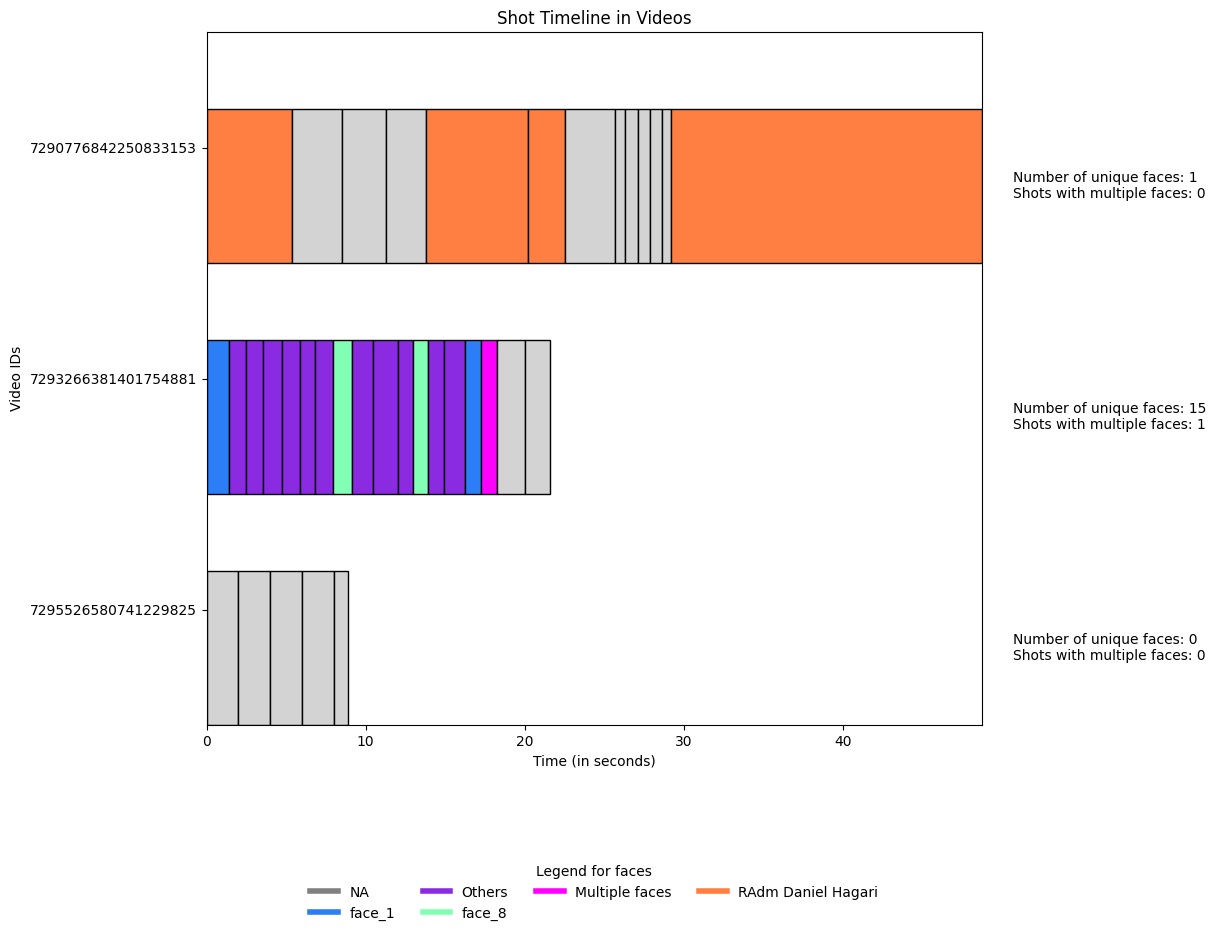

In [232]:
viz_face_timeline(mode="abs", df_scene=df_scene, match_threshold=2)

Processed video 7295526580741229825, total duration: 8.88s
Processed video 7293266381401754881, total duration: 21.6s
Processed video 7290776842250833153, total duration: 48.715s


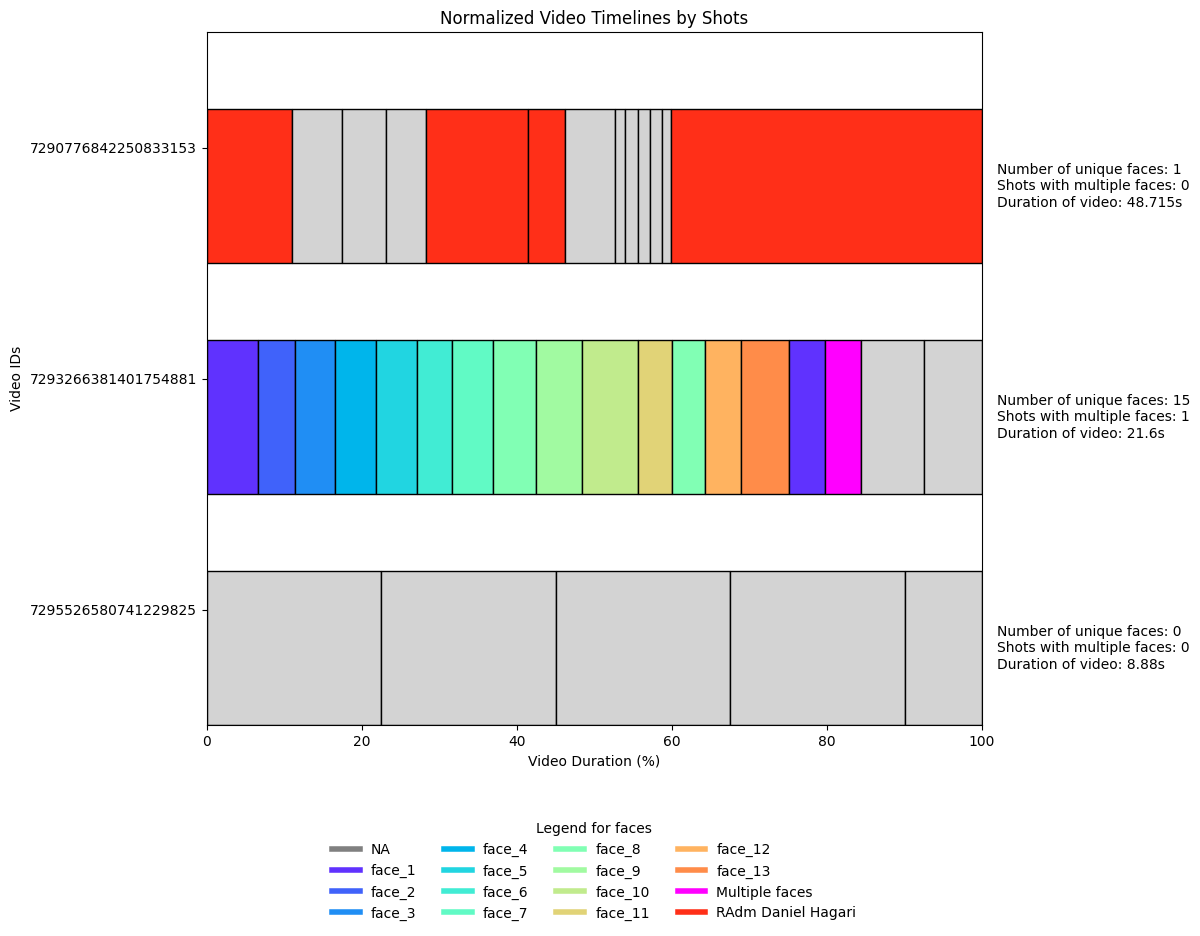

In [225]:
viz_face_timeline(mode="rel", df_scene=df_scene, match_threshold=0)

## Translating Shot Annotations to Video-level Annotations
Shot annotations are useful insofar as they allow us to understand a video's composition. Thus it is important for us to be able to translate these annotations to video-level.

We provide for two translation functions:
- ```shot2video_info()``` Translates basic shot information up to video level
- ```shot2video_feature```


### ```shot2video_info()``` Translates basic shot information up to video level
This function takes basic information already provided in the base scene metadata and translates it to video-level

**Information Translated**
- shot_count - Number of shots in the video
- total_duration - Total duration of video (in seconds)
- list_shotlength - List of shot lengths preserved
- asl - Average shot length of the video is also calculated
- cuts_per_min - The number of cuts per minute in the video; Used to calculate cutting rate as well

In [357]:
# Function to parse through scene information and return a new dataframe that is based on videoId

def shot2video_info(df_scene = df_scene):

    # Holding lists for dataframe addendum as we translate data
    id_list = []
    shotcount_list = []
    duration_list = []

    # Create new dataframe for scene data
    for _index_, row in df_scene.iterrows():

        id = row['url']
        if id not in id_list:
            id_list.append(id)
            shotcount = row['num_scenes_detected']
            duration = row['total_video_duration'].total_seconds()
            shotcount_list.append(shotcount)
            duration_list.append(duration)

            # print(f'Video ID: {id}')
            # print(f'Number of shots: {shotcount}')
            # print(f'Total duration: {duration}')

    # Create new df
    df_shotinfo = pd.DataFrame({'id':id_list, 'shot_count':shotcount_list, 'total_duration':duration_list})

    # Retain shot information
    shotdata_list = []
    for _index, row in df_shotinfo.iterrows():
        id = row['id']
        scene_shot_duration_list = []
        filtered_df = df_scene[df_scene['url'] == id]
        for _index, row in filtered_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']
            shot_duration = end_time - start_time
            shot_duration = shot_duration.total_seconds()
            scene_shot_duration_list.append(shot_duration)
        shotdata_list.append(scene_shot_duration_list)

    df_shotinfo['list_shotlength'] = shotdata_list

    # Calculate ASL
    df_shotinfo['asl'] = df_shotinfo['total_duration'] / df_shotinfo['shot_count']

    # Calculate MSL
    # df_shotinfo['msl'] = np.median(df_shotinfo['list_shotlength'])

    # Calculate cuts per min
    ## Theory is to understand the number of splits in a video
    df_shotinfo['cuts_per_min'] = (df_shotinfo['shot_count'] - 1) / (df_shotinfo['total_duration'] / 60)

    return df_shotinfo

In [358]:
df_video_update = shot2video_info(df_scene)
df_video_update

id  shot_count  total_duration  \
0  7295526580741229825           5           8.880   
1  7293266381401754881          18          21.600   
2  7290776842250833153          13          48.715   

                                     list_shotlength       asl  cuts_per_min  
0                         [2.0, 2.0, 2.0, 2.0, 0.88]  1.776000     27.027027  
1  [1.433, 1.034, 1.1, 1.166, 1.134, 0.966, 1.134...  1.200000     47.222222  
2  [5.339, 3.17, 2.769, 2.502, 6.44, 2.336, 3.136...  3.747308     14.779842

In [331]:
# Add translated data to main data 'df_video'
df_video = pd.merge(df_video, df_video_update, on='id', how='left')
df_video

id            thread_id author author_full  \
0  7295526580741229825  7295526580741229825    idf         IDF   
1  7294420810465430785  7294420810465430785    idf         IDF   
2  7293266381401754881  7293266381401754881    idf         IDF   
3  7293183558871551234  7293183558871551234    idf         IDF   
4  7290776842250833153  7290776842250833153    idf         IDF   

   author_followers  author_likes  author_videos  \
0            535900            80            875   
1            535900            80            875   
2            535900            80            875   
3            535900            80            875   
4            535900            80            875   

                                       author_avatar  \
0  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
1  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
2  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
3  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
4  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   

                                                body           timestamp  ...  \
0  In response to launches from Syria toward Isra... 2023-10-29 23:29:23  ...   
1  These words will never compare to the torture ... 2023-10-26 23:58:24  ...   
2  Individually we are strong, together we are a ... 2023-10-23 21:18:32  ...   
3  All the context you need //  #hamasisis #stand... 2023-10-23 15:57:10  ...   
4  IDF Spokesperson, RAdm. Daniel Hagari speaks a... 2023-10-17 04:17:51  ...   

   location_created                               stickers effects warning  \
0               NaN  Counter Speech 🚨 Operational Update 🚨     NaN     NaN   
1               NaN                                    NaN     NaN     NaN   
2               NaN                         Counter Speech     NaN     NaN   
3               NaN                                    NaN     NaN     NaN   
4               NaN                         Counter Speech     NaN     NaN   

  missing_fields shot_count         total_duration  \
0            NaN        5.0 0 days 00:00:08.880000   
1            NaN        NaN                    NaT   
2            NaN       18.0 0 days 00:00:21.600000   
3            NaN        NaN                    NaT   
4            NaN       13.0 0 days 00:00:48.715000   

                                     list_shotlength       asl cuts_per_min  
0  [0 days 00:00:02, 0 days 00:00:02, 0 days 00:0...  1.776000    27.027027  
1                                                NaN       NaN          NaN  
2  [0 days 00:00:01.433000, 0 days 00:00:01.03400...  1.200000    47.222222  
3                                                NaN       NaN          NaN  
4  [0 days 00:00:05.339000, 0 days 00:00:03.17000...  3.747308    14.779842  

[5 rows x 41 columns]

### ```shot2vid_feature()``` Translates categories in a defined feature column into video level

This function translates the annotations of a particular column into video-level annotations by calculating the proportion of how much a particular feature category occupies the video.

**Parameters**
- ```target_column``` - Column whose annotations will be translated

returns a dataframe in video-level ready to be merged with df_video

In [347]:
def shot2vid_feature(target_column, df_scene=df_scene):
    '''
    Translates scene level-annotations for a feature column into video-level annotations as a proportion (0.0-1.0) of how much a feature category occupies the video

    :param target_column: The name of the desired column where its features will be translated into
    :type target_column: str
    :param df_scene: The main scene metadata
    :return: df_video_out: The translated dataframe ready to be merged with df_video
    '''
    # Check if target_column is in df_scene
    if not target_column in df_scene.columns:
            raise ValueError("The dataframe lacks the desired target column. Please check again.")

    # Main calculation theory: Calculate the % a particular style feature occupies the video
    # Annotated to df_video: (sum of shot durations with style feature) / total duration of video

    # Obtain list of unique features
    feature_list = df_scene[target_column].unique()
    # Obtain list of videos
    video_list = df_scene['url'].unique()

    # Create an output dataframe for video-level data
    df_video_out = pd.DataFrame({'id': video_list})

    # Create shot duration column
    df_scene_copy = df_scene.copy()
    df_scene_copy['duration'] = df_scene_copy['end_time'].dt.total_seconds() - df_scene_copy['start_time'].dt.total_seconds()
    # Loop through each feature and calculate its percentage of total video duration
    for feature in feature_list:
        feature_durations = []

        for video in video_list:
            # Filter the dataframe for the current video
            df_video_shots = df_scene_copy[df_scene['url'] == video]

            # Filter shots that contain the current feature
            df_feature_shots = df_video_shots[df_video_shots[target_column] == feature]

            # Calculate total duration of shots with the feature
            feature_duration = df_feature_shots['duration'].sum()  # Sum shot-level durations

            # Calculate total video duration
            total_video_duration = df_video_shots.iloc[0]['total_video_duration'].total_seconds()

            # Calculate the percentage of the feature's duration in the video
            feature_percentage = (
                feature_duration / total_video_duration
                if total_video_duration > 0 else 0
            )

            # Append to the list for the current video
            feature_durations.append(feature_percentage)

        # Add the calculated feature percentages as a new column in the video-level dataframe
        # format name
        formatted_feature = feature.strip().lower().replace(" ", "_")
        df_video_out[f'{formatted_feature}_percentage'] = feature_durations

    return df_video_out


In [348]:
df_video_shotscale = shot2vid_feature("shot_scale")
df_video_shotscale

id  empty_shot_percentage  full_shot_percentage  \
0  7295526580741229825               1.000000               0.00000   
1  7293266381401754881               0.155880               0.84412   
2  7290776842250833153               0.094509               0.82878   

   long_shot_percentage  
0              0.000000  
1              0.000000  
2              0.076711